In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits as mplot3d

pd.set_option("display.max_columns", None)
pd.set_option('future.no_silent_downcasting', True)

from tqdm import tqdm
tqdm.pandas()

In [2]:
import_folder_path = rf"../../data_cleaned/india/dynata"

# DATA WRANGLING

In [3]:
df00 = pd.read_csv(rf"{import_folder_path}/Indian Risk Literacy DYNATA_280525.csv")[26:]
df00[["Q9b_11", "Q9b_5", "Q9b_6", "Q9b_12"]] = df00[["Q9b_11", "Q9b_5", "Q9b_6", "Q9b_12"]].astype(float)
df00["Q9b_11"] = df00["Q9b_5"] + df00["Q9b_11"]
df00["Q9b_12"] = df00["Q9b_6"] + df00["Q9b_12"]
df00.drop(["Q9b_5", "Q9b_6"], axis = 1, inplace = True)
# 
df00.rename({"ResponseId":"responseid"}, axis = 1, inplace = True)

# drop na in responses
df01 = df00.dropna(subset = df00.columns[19:77])
print("Post dropping NA:", len(df01["responseid"]))

# removing students
df01 = df01.loc[ ~(df01["Q4a"] == "Student")].copy()
print("Post removing students:", len(df01["responseid"]))

# removing straight liners
matrix = ["Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8"]
conversion_dict = {"1 (strongly disagree)":1 , "2":2, "3":3, "4":4, "5":5, "6 (strongly agree)":6}
for ques in matrix:
    df01[ques] = df01[ques].astype(str).replace(conversion_dict)

df01[ques] = pd.to_numeric(df01[ques], errors='coerce')

df01["Q8_std"] = df01[matrix].std(axis = 1)
df01 = df01.loc[ df01["Q8_std"] != 0].copy()
print("Post removing straightliners:", len(df01["responseid"]))

# attention check
df01 = df01.loc[ df01["Attention Check"] == "Vase"].copy()
print("Post attention chaeck failures:", len(df01["responseid"]))

# <0.5 median time of completion filtered
df01["Duration (in seconds)"] = df01["Duration (in seconds)"].astype("Int64")
median = df01["Duration (in seconds)"].astype("Int64").median()
df01 = df01.loc[ df01["Duration (in seconds)"] >= median*0.5].copy()
print("Post removing <0.5 median time responses:", len(df01["responseid"]))

# # ONLY SALARIED 
# df01 = df01.loc[ df01["Q4a"] == "Salaried"].copy()
# print("Post removing non-salaried responses:", len(df01["responseid"]))

df0 = df01.iloc[:, 19:77].copy().reset_index(drop = True)
df0.insert(0, "responseid", range(0, len(df0)))

Post dropping NA: 963
Post removing students: 961
Post removing straightliners: 846
Post attention chaeck failures: 846
Post removing <0.5 median time responses: 699


In [4]:
df0["age"] = df0["Q2"].astype(float).copy()
df0["gender_text"] = df0["Q1"]

# Age groups/rec = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)

df0["age_rec"] = np.where( (df0["age"] >= 18) & (df0["age"] <= 35), 2,
                          np.where( (df0["age"] >= 36) & (df0["age"] <= 55), 3,
                                   np.where( (df0["age"] >= 56), 4, 0
                                           )
                                  )
                         )

# Secondary upto 10 – ISCED 3
# Senior Secondary upto 12 - ISCED 3 
# Diploma and voca – ISCED 2
# UG – ISCED 2
# PG – ISCED 1
# PhD and higher – ISCED 1

df0["isced"] = np.where(df0["Q3"] == "Post-Graduate Program", 1,
                        np.where(df0["Q3"] == "Undergraduate Program", 2,
                                 np.where(df0["Q3"] == "Ph.D. and higher", 1,
                                          np.where(df0["Q3"] == "Diploma and Vocational Training", 2,
                                                   np.where(df0["Q3"] == "Secondary School (11th to 12th Std.)", 3,
                                                            np.where( df0["Q3"] == "Primary School (up to 10th Std.)", 3,
                                                                     np.where( df0["Q3"] == "M.Phil.", 1, 0
                                                                             )
                                                                    )
                                                           )
                                                  )
                                         )
                                )
                       )

df0["income"] = np.where(df0["Q15a"] == "< INR 500,000", 1,
                         np.where(df0["Q15a"] == "INR 500,001 – INR 15,00,000", 2,
                                  np.where(df0["Q15a"] == "INR 1500,001 – INR 30,00,000", 3,
                                           np.where(df0["Q15a"] == "INR 30,00,001 – INR 50,00,000", 4,
                                                    np.where(df0["Q15a"] == "INR 50,00,001 – INR 75,00,000", 5,
                                                             np.where( df0["Q15a"] == "> INR 75,00,000", 6, -1
                                                                     )
                                                            )
                                                   )
                                           )
                                  )
                         )

df0["wealth"] = df0["Q14b"].astype(float).copy()

In [5]:
def remove_indexname(series): # removes index name
    series.index.name = None
    series.name = None
    return series.to_string()

print("Total Observations:", df0["Q1"].count())

print(f'\nGender:\n{remove_indexname(df0["Q1"].value_counts())}')
print(f'\nOccupation:\n{remove_indexname(df0["Q4a"].value_counts())}')
print(f'\nEducation:\n{remove_indexname(df0["Q3"].value_counts())}')
print(f'\nISCED:\n{remove_indexname(df0["isced"].value_counts())}')

vc_income = df0["Q15a"].value_counts()
income = vc_income.iloc[[1, 0, 2, 3, 4, 5]]
print(f'\nIncome:\n{remove_indexname(income)}')

Total Observations: 699

Gender:
Male      361
Female    338

Occupation:
Salaried                       490
Entrepreneur/Business Owner    129
Currently not employed          68
Retired                         12

Education:
Post-Graduate Program                   225
Undergraduate Program                   206
Secondary School (11th to 12th Std.)    177
Diploma and Vocational Training          35
Primary School (up to 10th Std.)         29
Ph.D. and higher                         16
M.Phil.                                  11

ISCED:
1    252
2    241
3    206

Income:
< INR 500,000                    194
INR 500,001 – INR 15,00,000      221
INR 1500,001 – INR 30,00,000     114
INR 30,00,001 – INR 50,00,000     76
INR 50,00,001 – INR 75,00,000     52
> INR 75,00,000                   42


## Winsorizing Wealth: No winsorizing happening yet, look for top values, and their frequency

In [6]:
## Winsorizing Wealth

from scipy.stats.mstats import winsorize

def winsorize_output(sample, variable, limits = [0, 0]):
    sample[f"nonwinsorised_{variable}"] = sample[variable]
    sample[f"winsorised_{variable}"] = winsorize(np.array(sample[f"nonwinsorised_{variable}"]), limits = limits, inclusive = [False, False])
    sample[[f"nonwinsorised_{variable}", f"winsorised_{variable}"]].describe()
    print(sample[[f"winsorised_{variable}", f"nonwinsorised_{variable}"]].describe())
    print("\n\nTop values and their count: ", (sample[f"nonwinsorised_{variable}"].value_counts().sort_index().tail(n=10)))
    print("\n\n")
    
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))
    sns.kdeplot(data = sample[f"nonwinsorised_{variable}"].replace([np.inf, -np.inf], np.nan), ax = axes[0])
    axes[0].set_title(f'Nonwinsorised {variable}')
    sns.kdeplot(data = sample[f"winsorised_{variable}"].replace([np.inf, -np.inf], np.nan), ax = axes[1])
    axes[1].set_title(f'Winsorized {variable}')
    plt.tight_layout()
    plt.show()

    sample[variable] = sample[f"winsorised_{variable}"]
    return sample[variable]

       winsorised_wealth  nonwinsorised_wealth
count       6.990000e+02          6.990000e+02
mean        1.628566e+08          1.628566e+08
std         3.794346e+09          3.794346e+09
min         0.000000e+00          0.000000e+00
25%         1.000000e+05          1.000000e+05
50%         6.000000e+05          6.000000e+05
75%         4.000000e+06          4.000000e+06
max         1.000000e+11          1.000000e+11


Top values and their count:  nonwinsorised_wealth
9.000000e+07    1
1.000000e+08    3
1.100000e+08    1
1.500000e+08    2
1.565000e+08    1
2.000000e+08    1
3.000000e+08    1
1.000000e+09    1
8.144789e+09    1
1.000000e+11    1
Name: count, dtype: int64





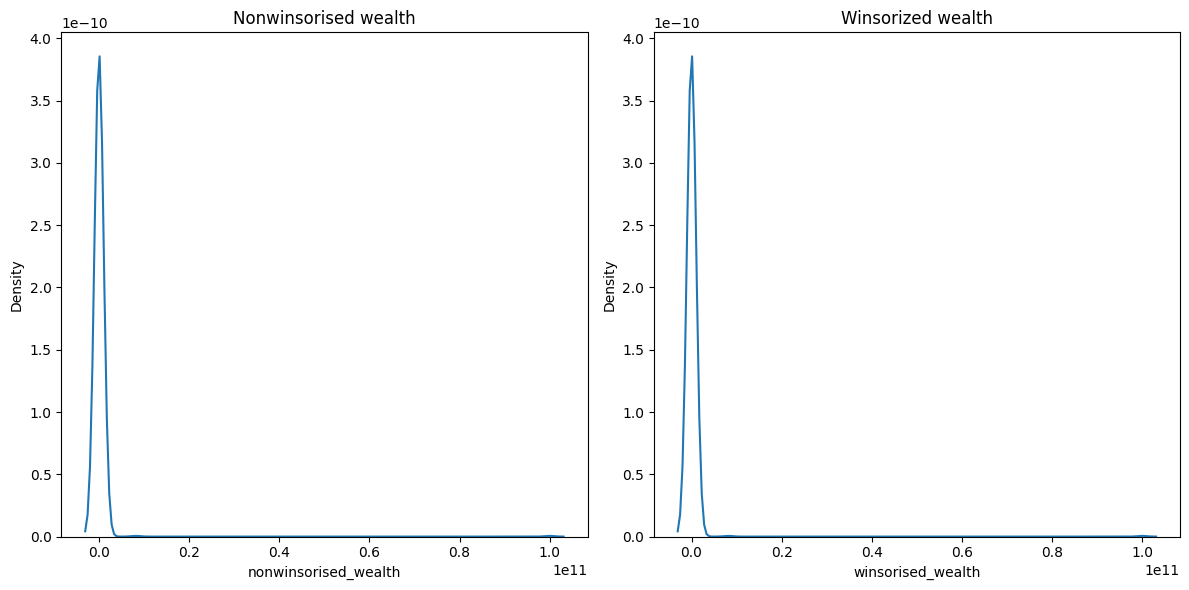

In [7]:
winsorized_wealth = winsorize_output(df0, "wealth", [0, 0])

In [8]:
# Using winsorised wealth as wealth
df0["wealth"] = winsorized_wealth

## Questions

In [9]:
df0.columns

Index(['responseid', 'Q1', 'Q2', 'Q3', 'Q4a', 'Q4.5_4', 'Q4.5_5', 'Q4.5_6',
       'Q5_1', 'Q6 - changed', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6',
       'Q8_7', 'Q8_8', 'Q9b_1', 'Q9b_4', 'Q9b_10', 'Q9b_11', 'Q9b_12', 'Q9b_7',
       'Q9b_8', 'Q9b_13', 'Q9b_14', 'Q9b_9', 'Q14b', 'Q11a_1', 'Q11a_2',
       'Q11a_3', 'Q11b_1', 'Q11b_2', 'Q11b_3', 'Q11b_4', 'Q11b_5', 'Q11c',
       'Q11d', 'Q11h', 'Attention Check', 'Q11i', 'Q13a', 'Q13b', 'Q13c',
       'Q13d', 'Q12a', 'Q12b', 'Q12c', 'Q14a', 'Q14b.1', 'Q14c', 'Q54', 'Q57',
       'Q58', 'Q15a', 'psid', 'entrySigCheck', 'verification', 'age',
       'gender_text', 'age_rec', 'isced', 'income', 'wealth',
       'nonwinsorised_wealth', 'winsorised_wealth'],
      dtype='object')

In [10]:
df0["q8_2_1"] = np.where(df0["Q11b_1"] == "No", 1, 2)
df0["q8_2_2"] = np.where(df0["Q11b_2"] == "No", 1, 2)
df0["q8_2_3"] = np.where(df0["Q11b_3"] == "No", 1, 2)
df0["q8_2_4"] = np.where(df0["Q11b_4"] == "No", 1, 2)
df0["q8_2_5"] = np.where(df0["Q11b_5"] == "No", 1, 2)

df0["q8_3"] = np.where(df0["Q11c"] == "The lower the quality of the study, the more likely that future studies will change the risk estimate.", 1,
                          np.where(df0["Q11c"] == "The higher the quality of the study, the more likely that future studies will change the risk estimate.", 2,
                                  np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will not change the risk estimate.", 3,
                                          np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will change the risk estimate substantially anyway.", 4,0
                                                  )
                                          )
                                  )
                         )


df0["q8_4"] = np.where(df0["Q11d"] == "The growth rate will be 0.4% on average each year", 1,
                          np.where(df0["Q11d"] == "The growth rate over five years will be exactly 2%", 2,
                                  np.where(df0["Q11d"] == "The growth rate over five years will be between 1% and 3%", 3,
                                          np.where(df0["Q11d"] == "It is not possible to predict the growth rate with certainty", 4,0
                                                  )
                                          )
                                  )
                         )

In [11]:
df0["q8_5berlin_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)
df0["q8_5london_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)
df0["q8_5paris_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)

df0["q8_6"] = np.where(df0["Q11i"] == "The medication increases recovery by 100%", 1,
                          np.where(df0["Q11i"] == "The medication increases recovery by 50%", 2,
                                   np.where(df0["Q11i"] == "The medication increases recovery by 2%", 3,
                                            np.where(df0["Q11i"] == "None of the above is implied", 4, 0
                                                    )
                                           )
                                  )
                         )

df0["q8_7"] = np.where(df0["Q11h"] == "5 in 100 people prior to the intervention to 6 out of 100 people after the intervention", 1,
                          np.where(df0["Q11h"] == "100 in 10,000 people prior to the intervention to 120 out of 10,000 people after the intervention", 2,
                                   np.where(df0["Q11h"] == "70 in 100 people prior to the intervention to 90 out of 100 people after the intervention", 3,
                                            np.where(df0["Q11h"] == "It is not possible to determine which of the answers is correct given the information provided", 4, 0
                                                    )
                                           )
                                  )
                         )


df0["q9_1_1"] = df0["Q14a"].astype(float).copy()
df0["q9_2_1"] = df0["Q14b.1"].astype(float).copy()

df0["q9_3"] = np.where(df0["Q14c"] == "Crosicol", 1,
                          np.where(df0["Q14c"] == "Hertinol", 2,
                                   np.where(df0["Q14c"] == "They are equal", 3,
                                            np.where(df0["Q14c"] == "Can’t say", 4, 0
                                                    )
                                           )
                                  )
                         )

In [12]:
df0["q10_1_1"] = df0["Q13a"].astype(float).copy()
df0["q10_2_1"] = df0["Q13b"].astype(float).copy()
df0["q10_3_1"] = df0["Q13c"].astype(float).copy()

df0["q10_4"] = np.where(df0["Q13d"] == "9 out of 59", 1,
                          np.where(df0["Q13d"] == "9 out of 10", 2,
                                   np.where(df0["Q13d"] == "59 out of 1000", 3,
                                            np.where(df0["Q13d"] == "59 out of 100", 4, 0
                                                    )
                                           )
                                  )
                         )

In [13]:
# Dynata Only

further_analysis_cols = [
    "Q5_1", "Q6 - changed",
    "Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8",
    "Q9b_1", "Q9b_4", "Q9b_10", "Q9b_11", "Q9b_12",
    "Q9b_7", "Q9b_8", "Q9b_13", "Q9b_14",
    "Q12a", "Q12b", "Q12c"
    ] # not used


df0["Q5_1"] = df0["Q5_1"].astype(str)
df0["Q5_score"] = np.where(df0["Q5_1"] == "0 (unwilling to take risk)", 0,
                           np.where(df0["Q5_1"] == "1", 1,
                                    np.where(df0["Q5_1"] == "2", 2,
                                             np.where(df0["Q5_1"] == "3", 3,
                                                  np.where(df0["Q5_1"] == "4", 4,
                                                           np.where(df0["Q5_1"] == "5", 5,
                                                                    np.where(df0["Q5_1"] == "6", 6,
                                                                             np.where(df0["Q5_1"] == "7 (willing to take risk)", 7, -1
                                                                                      )
                                                                             )
                                                                    )
                                                           )
                                                      )
                                             )
                                    )
                           )

df0["Q6 - changed"] = df0["Q6 - changed"].astype(str)
df0["Q6_score"] = np.where(df0["Q6 - changed"] == "Definitely no experience", 0,
                           np.where(df0["Q6 - changed"] == "Rather little experience", 1,
                                        np.where(df0["Q6 - changed"] == "Some experience", 2,
                                                 np.where(df0["Q6 - changed"] == "Rather much experience", 3,
                                                          np.where(df0["Q6 - changed"] == "Definitely very much experience", 4, -1
                                                                   )
                                                          )
                                                 )
                                        )
                           )

# financial planning 2
cols = ["Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8"]
df0[cols] = df0[cols].astype(int)
df0["Q8_total"] = df0[cols].sum(axis = 1)

# financial planning 1
cols = ["Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6"]
df0[cols] = df0[cols].astype(int)
df0["Q8a_total"] = df0[cols].sum(axis = 1)

# safe assets
cols = ["Q9b_1", "Q9b_4", "Q9b_10", "Q9b_11", "Q9b_12"]
df0[cols] = df0[cols].astype(float)
df0["Q9_safe_total"] = df0[cols].sum(axis = 1)

# risky assets
cols = ["Q9b_7", "Q9b_8", "Q9b_13", "Q9b_14", "Q9b_9"]
df0[cols] = df0[cols].astype(float)
df0["Q9_risky_total"] = df0[cols].sum(axis = 1)

# Financial Literacy
cols = ["Q12a", "Q12b", "Q12c"]
df0[cols] = df0[cols].astype("string")

df0["Q12a_score"] = np.where(df0["Q12a"] == "More than INR 102", 1, 0)
df0["Q12b_score"] = np.where(df0["Q12b"] == "Less than today with the money in this account", 1, 0)
df0["Q12c_score"] = np.where(df0["Q12c"] == "False", 1, 0)

cols = ["Q12a_score", "Q12b_score", "Q12c_score"]
df0["Q12_total"] = df0[cols].sum(axis = 1)

# CRT
cols = ["Q54", "Q57", "Q58"]
df0[cols] = df0[cols].astype(float)

df0["Q54_score"] = np.where((df0["Q54"] == 5) | (df0["Q54"] == 0.05), 1, 0)
df0["Q57_score"] = np.where(df0["Q57"] == 5, 1, 0)
df0["Q58_score"] = np.where(df0["Q58"] == 47, 1, 0)

cols = ["Q54_score", "Q57_score", "Q58_score"]
df0["crt_total"] = df0[cols].sum(axis = 1)

# Financial Planning
cols = ["Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8"]
for i, col in enumerate(cols):
    if i == 6:
        df0.rename({col:f"financialplanning_emergency"}, axis = 1, inplace = True)
    elif i == 7:
        df0.rename({col:f"financialplanning_retirement"}, axis = 1, inplace = True)

    else:
        df0.rename({col:f"financialplanning_{i+1}"}, axis = 1, inplace = True)

# asset classes
asset_classes_dict = {"Q9b_1":"savings_bank", "Q9b_4":"fixed_deposits",
                    "Q9b_10":"recurring_deposits", "Q9b_11":"gov_bonds",
                    "Q9b_12":"corp_bonds", "Q9b_7":"mutual_funds",
                    "Q9b_8":"stocks", "Q9b_13":"real_estate",
                    "Q9b_14":"commodities", "Q9b_9":"other_invest"}

df0.rename(asset_classes_dict, axis = 1, inplace = True)


cols = ["savings_bank", "gov_bonds", "mutual_funds", "stocks"]
for col in cols:
    df0[f"{col}_dummy"] = np.where(df0[col] > 0, 1, 0)
    if col == "savings_bank":
        savings_col = ["savings_bank", "fixed_deposits", "recurring_deposits", "gov_bonds",
                       "corp_bonds", "mutual_funds", "stocks"]
        df0[f"{col}_dummy"] = np.where(df0[savings_col].sum(axis = 1) > 0, 1, 0)

df0["investment_behaviour"] = df0[[col + "_dummy" for col in cols]].sum(axis = 1)
df0["investments"] = df0[["gov_bonds", "corp_bonds", "mutual_funds",
                          "stocks", "real_estate", "commodities", "other_invest"]].sum(axis = 1) 

df0["risky_investments"] = df0[["mutual_funds", "stocks", "real_estate", "commodities", "other_invest"]].sum(axis = 1) 

## SCORING

In [14]:
focal_col = ["q8_2_1", "q8_2_2", "q8_2_3", "q8_2_4", "q8_2_5",
             "q8_3", "q8_4",
             "q8_5berlin_1", "q8_5london_1", "q8_5paris_1", "q8_6", "q8_7",
             "q9_1_1", "q9_2_1", "q9_3",
             "q10_1_1", "q10_2_1", "q10_3_1", "q10_4"]

for col in focal_col:
    df0[col] = df0[col].astype(float)

scoreColumns = ["certainty1", "certainty2", "certainty3", "certainty4", "certainty5",
"uncertainty1", "uncertainty2",
"numeracy1", "numeracy2", "numeracy3", # "numeracy4", "numeracy5",
"graph1", "graph2", "graph3",
"riskcomprehension1", "riskcomprehension2", "riskcomprehension3", "riskcomprehension4", "riskcomprehension5",
"bayesian1"
]

# Dynata Only
req_cols = [
    "riskappetite", "investmentxp", "financialplanning1", "financialplanning2",
    "riskyassets_%", "safeassets_%",
    "financialliteracy", "crtscore"]

df0[scoreColumns + req_cols] = 0.0
df0 = df0.copy()

/tmp/ipykernel_407714/2552271643.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df0[scoreColumns + req_cols] = 0.0
/tmp/ipykernel_407714/2552271643.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df0[scoreColumns + req_cols] = 0.0
/tmp/ipykernel_407714/2552271643.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `

In [15]:
# Assigning scores

def scoring1(surveyFacet):
    surveyFacet.loc[ surveyFacet["q8_2_1"] == 2, "certainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_2"] == 2, "certainty2"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_3"] == 2, "certainty3"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_4"] == 2, "certainty4"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_5"] == 2, "certainty5"] = 1

    surveyFacet.loc[ surveyFacet["q8_3"] == 1, "uncertainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_4"] == 4, "uncertainty2"] = 1

    surveyFacet.loc[ surveyFacet["q8_5berlin_1"] == 2, "riskcomprehension1"] = 1
    surveyFacet.loc[ surveyFacet["q8_5london_1"] == 1, "riskcomprehension2"] = 1
    surveyFacet.loc[ surveyFacet["q8_5paris_1"] == 1, "riskcomprehension3"] = 1
    
    surveyFacet.loc[ surveyFacet["q8_6"] == 1, "riskcomprehension4"] = 1
    surveyFacet.loc[ surveyFacet["q8_7"] == 4, "riskcomprehension5"] = 1

    surveyFacet.loc[ surveyFacet["q9_1_1"] == 25, "graph1"] = 1
    surveyFacet.loc[ surveyFacet["q9_2_1"] == 20, "graph2"] = 1
    surveyFacet.loc[ surveyFacet["q9_3"] == 3, "graph3"] = 1

    surveyFacet.loc[ surveyFacet["q10_1_1"] == 500, "numeracy1"] = 1
    surveyFacet.loc[ surveyFacet["q10_2_1"] == 10, "numeracy2"] = 1
    surveyFacet.loc[ (surveyFacet["q10_3_1"] == 0.1) | (surveyFacet["q10_3_1"] == ".1") | (surveyFacet["q10_3_1"] == ",1") , "numeracy3"] = 1
    surveyFacet.loc[ surveyFacet["q10_4"] == 1, "bayesian1"] = 1

    # Dynata Only
    surveyFacet.loc[:, "riskappetite"] = surveyFacet["Q5_score"]
    surveyFacet.loc[:, "investmentxp"] = surveyFacet["Q6_score"]
    
    surveyFacet.loc[:, "financialplanning2"] = surveyFacet["Q8_total"]
    surveyFacet.loc[:, "financialplanning1"] = surveyFacet["Q8a_total"]

    surveyFacet.loc[:, "riskyassets_%"] = surveyFacet["Q9_risky_total"]
    surveyFacet.loc[:, "safeassets_%"] = surveyFacet["Q9_safe_total"]
    
    surveyFacet.loc[:, "financialliteracy"] = surveyFacet["Q12_total"]

    surveyFacet.loc[:, "crtscore"] = surveyFacet["crt_total"]

    

    
    # Assigning total scores
    # surveyFacet["Certainty score_5"] = surveyFacet["certainty1"] + surveyFacet["certainty2"] + surveyFacet["certainty3"] + surveyFacet["certainty4"] + surveyFacet["certainty5"]
    #surveyFacet["Uncertainty score_5"] = surveyFacet["uncertainty1"] + surveyFacet["uncertainty2"]

    #surveyFacet["Number Comprehension score_5"] = surveyFacet["numeracy1"] + surveyFacet["numeracy2"] + surveyFacet["numeracy3"] + surveyFacet["numeracy4"] + surveyFacet["numeracy5"]
    #surveyFacet["Graph Comprehension score_5"] = surveyFacet["graph1"] + surveyFacet["graph2"] + surveyFacet["graph3"]

    #surveyFacet["Calculation score_4"] = surveyFacet["riskcalculation1"] + surveyFacet["riskcalculation2"] + surveyFacet["riskcalculation3"] + surveyFacet["riskcalculation4"]

    #surveyFacet["Total Score_19"] = surveyFacet["Certainty score_5"] + surveyFacet["Uncertainty score_5"] + surveyFacet["Number Comprehension score_5"] + surveyFacet["Graph Comprehension score_5"] + surveyFacet["Calculation score_4"]

    return surveyFacet

In [16]:
df1 = df0.groupby(["responseid"]).progress_apply(scoring1)
df1 = df1.reset_index(drop = True).copy()

 99%|█████████▊| 689/699 [00:04<00:00, 150.00it/s]/home/leshleon/projects/Risk Literacy/.venv/lib/python3.12/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 699/699 [00:04<00:00, 146.35it/s]


In [17]:
def scoring2(survey):
    
    survey["Certainty_5"] = survey["certainty1"] + survey["certainty2"] + survey["certainty3"] + survey["certainty4"] + survey["certainty5"]
    
    survey["Uncertainty_2"] = survey["uncertainty1"] + survey["uncertainty2"]
    
    survey["RiskComprehension_5"] = survey["riskcomprehension1"] + survey["riskcomprehension2"] + survey["riskcomprehension3"] + survey["riskcomprehension4"] + survey["riskcomprehension5"]
    
    survey["GraphLiteracy_3"] = survey["graph1"] + survey["graph2"] + survey["graph3"]
    
    survey["Numeracy_3"] = survey["numeracy1"] + survey["numeracy2"] + survey["numeracy3"]
    
    survey["Bayesianreasoning_1"] = survey["bayesian1"]
    
    survey["TotalScore_19"] = survey["Certainty_5"] + survey["Uncertainty_2"] + survey["RiskComprehension_5"] + survey["GraphLiteracy_3"] + survey["Numeracy_3"] + survey["Bayesianreasoning_1"]
    
    survey["Certainty_%"] = survey["Certainty_5"] / 5 * 100
    survey["Uncertainty_%"] = survey["Uncertainty_2"] / 2 * 100
    survey["RiskComprehension_%"] = survey["RiskComprehension_5"] / 5 * 100
    survey["GraphLiteracy_%"] = survey["GraphLiteracy_3"] / 3 * 100
    survey["Numeracy_%"] = survey["Numeracy_3"] / 3 * 100
    survey["Bayesianreasoning_%"] = survey["Bayesianreasoning_1"] / 1 * 100
    
    survey["TotalScore_%"] = survey["TotalScore_19"] / 19 * 100

    #Dynata Only
    survey["RiskAppetite_7"] = survey["riskappetite"]
    survey["InvestmentXP_4"] = survey["investmentxp"]
    
    survey["FinancialPlanning1_6"] = survey["financialplanning1"] / 6
    survey["FinancialPlanning2_6"] = survey["financialplanning2"] / 8

    survey["RiskAssets_%"] = survey["riskyassets_%"]
    survey["RiskAlignment"] = survey["RiskAppetite_7"] * 100 / 7
    survey["RiskAlignment_residual"] = survey["RiskAssets_%"] - survey["RiskAlignment"]
    survey["RiskAlignment_felix"] = survey["RiskAssets_%"] * 7 / 100

    survey["SafeAssets_%"] = survey["safeassets_%"]
    
    survey["FinancialLiteracy_3"] = survey["financialliteracy"]

    survey["CRTScore_3"] = survey["crtscore"]

    survey["RiskAppetite1_%"] = survey["RiskAppetite_7"] / 7 * 100
    survey["RiskAppetite2_%"] = survey["InvestmentXP_4"] / 4 * 100

    survey["FinancialPlanning1_%"] = survey["FinancialPlanning1_6"] / 6 * 100
    survey["FinancialPlanning2_%"] = survey["FinancialPlanning2_6"] / 6 * 100

    survey["FinancialLiteracy_%"] = survey["FinancialLiteracy_3"] / 3 * 100
    survey["CRTScore_%"] = survey["CRTScore_3"] / 3 * 100

    survey["country_text"] = "India"
    survey["country"] = 0
    
     
    colReq1 = [
        "responseid", "country_text", "country", "age", "gender_text", "age_rec", "isced", "income", "wealth", "Certainty_5", "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3",
        "Numeracy_3", "Bayesianreasoning_1", "Certainty_%", "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%", "Numeracy_%", "Bayesianreasoning_%",
        "TotalScore_19", "TotalScore_%",
        #Dynata only
        "RiskAssets_%", "SafeAssets_%", "RiskAlignment", "RiskAlignment_residual", "RiskAlignment_felix",
        "RiskAppetite1_%", "RiskAppetite_7", "RiskAppetite2_%", "InvestmentXP_4",
        "FinancialPlanning1_6", "FinancialPlanning2_6", "FinancialPlanning1_%", "FinancialPlanning2_%",
        "FinancialLiteracy_%", "FinancialLiteracy_3",
        "CRTScore_3", "CRTScore_%"
    ]

    colReq2 = [
    "financialplanning_1", "financialplanning_2", "financialplanning_3", "financialplanning_4",
    "financialplanning_5", "financialplanning_6", "financialplanning_emergency", "financialplanning_retirement", 

    "savings_bank", "fixed_deposits", "recurring_deposits", "gov_bonds", "corp_bonds",
    "mutual_funds", "stocks", "real_estate", "commodities", "other_invest",

    "savings_bank_dummy", "gov_bonds_dummy", "mutual_funds_dummy", "stocks_dummy",
    "investment_behaviour", "risky_investments", "investments"
    ]
    
    survey1 = survey[colReq1 + scoreColumns + colReq2].copy()
    return survey1

In [18]:
df2 = scoring2(df1)

In [19]:
main = df2.copy()

## Income Terciles and Quartiles

How to Form Terciles from Categorical Data

If your categorical data has a natural order (ordinal data), you can divide it into terciles—three groups each containing approximately one-third of the observations—by following these steps:
1. List the Categories in Order
Arrange your categories from lowest to highest based on their natural order.
2. Count Observations in Each Category
Determine the number of observations in each category.
3. Calculate Cumulative Percentages
For each category, calculate the cumulative percentage of observations up to and including that category.
4. Assign Tercile Groups:
The first tercile includes categories up to the point where the cumulative percentage reaches or exceeds 33.3%.
The second tercile includes categories up to the point where the cumulative percentage reaches or exceeds 66.7%.
The third tercile includes the remaining categories.
6. A single Tercile muct never exceed 50% of the sample. If a Tercile exceeds 50% of the sample then it needs to be split up for the price of the Cumulative percentage being lower than 33.3% per Tercile.

How to Form Quartiles from Categorical Data

If your categorical data has a natural order (ordinal data), you can divide it into quartiles—three groups each containing approximately one-third of the observations—by following these steps:
1. List the Categories in Order
Arrange your categories from lowest to highest based on their natural order.
2. Count Observations in Each Category
Determine the number of observations in each category.
3. Calculate Cumulative Percentages
For each category, calculate the cumulative percentage of observations up to and including that category.
4. Assign Quartile Groups:
The first quartile includes categories up to the point where the cumulative percentage reaches or exceeds 25%.
The second quartile includes categories up to the point where the cumulative percentage reaches or exceeds 50%.
The third quartile includes categories up to the point where the cumulative percentage reaches or exceeds 75%.
The fourth quartile includes the remaining categories.
6. A single Quartile muct never exceed 50% of the sample. If a Quartile exceeds 50% of the sample then it needs to be split up for the price of the Cumulative percentage being lower than 33.3% per Quartile.

In [20]:
main["income"].value_counts().sort_index() / len(main) * 100

income
1    27.753934
2    31.616595
3    16.309013
4    10.872675
5     7.439199
6     6.008584
Name: count, dtype: float64

### Income Terciles
1 - income = 1 --> 194 (194)

2 - income = 2 3 --> 335 (114 + 221)

3 - income = 4 5 6 --> 170 (76 + 52 + 42)

In [21]:
main["income_tercile"] = np.where(main["income"] == 1, 1,
                                  np.where(main["income"] == 2, 2,
                                           np.where(main["income"] == 3, 2,
                                                    np.where(main["income"] == 4, 3,
                                                             np.where(main["income"] == 5, 3,
                                                                      np.where(main["income"] == 6, 3, -1
                                                                              )
                                                                     )
                                                            )
                                                   )
                                          )
                                 )                                  

### Income Quartiles
1 - income = 1 --> 27.7 (27.7)

2 - income = 2 --> 31.6 (31.6)

3 - income = 3 4 --> 27.1 (16.3 + 10.8)

4 - income = 5 6 --> 13.4 (7.4 + 6.0)

In [22]:
main["income_quartile"] = np.where(main["income"] == 1, 1,
                                   np.where(main["income"] == 2, 2,
                                           np.where(main["income"] == 3, 3,
                                                    np.where(main["income"] == 4, 3,
                                                             np.where(main["income"] == 5, 4,
                                                                      np.where(main["income"] == 6, 4, -1
                                                                               )
                                                                      )
                                                             )
                                                    )
                                           )
                                   )   

## Wealth Quartile and Risk Quartile

In [23]:
wealth_quartile = pd.qcut(main.loc[~ (main["wealth"]==-1)]["wealth"],q = 4, labels = False, duplicates = "raise" ) + 1
main["wealth_quartile"] = wealth_quartile

main["risklit_quartile_income"] = pd.qcut(main.loc[~ (main["income"]==-1)]["TotalScore_%"],q = 4, labels = False, duplicates = "raise" ) + 1
main["risklit_quartile_wealth"] = pd.qcut(main.loc[~ (main["wealth"]==-1)]["TotalScore_%"],q = 4, labels = False, duplicates = "raise" ) + 1

In [24]:
main.to_pickle("India_Dynata_dataset.pkl")

--------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------

In [26]:
#Global Vras:
facet_cols = ["Certainty_5", "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3",
              "Numeracy_3", "Bayesianreasoning_1"]

facet_percent_cols = ["Certainty_%", "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%",
                      "Numeracy_%", "Bayesianreasoning_%",]

# Study 2 - India Dynata

## Graph 1.0 - Total Score Frequency Distribution

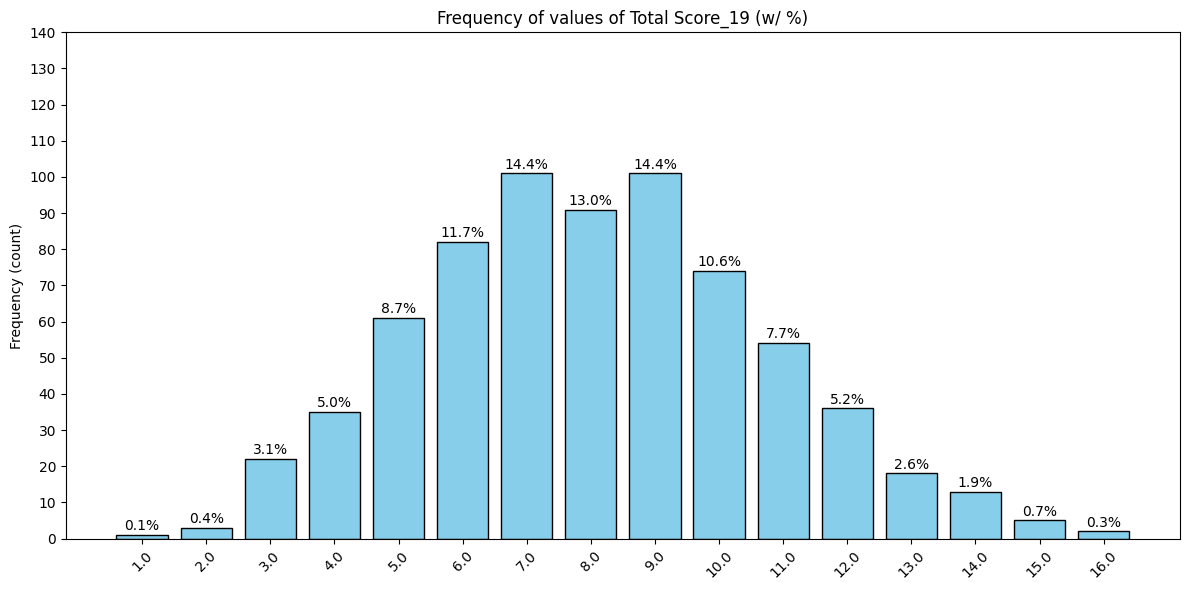

In [27]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

sample = main["TotalScore_19"].value_counts().sort_index()
x = sample.index
y = sample.values
total = sample.sum()

axes.bar(x, y, color="skyblue", edgecolor='black')

for j, value in zip(sample.index, sample.values):
    axes.text(j, value + 0.5, f"{value/total * 100:.1f}%", ha = "center", va = "bottom", fontsize=10, color="black")

axes.set_yticks(np.arange(0, 150, step = 10))
axes.set_xticks(x)
axes.set_xticklabels(x, rotation = 45, ha = "center")

axes.set_ylabel(f"Frequency (count)")
axes.set_title(f"Frequency of values of Total Score_19 (w/ %)")

plt.tight_layout()
plt.show()

## Table 1.1 - Mean Total Score + SD

Text(0, 0.5, 'Mean Total score')

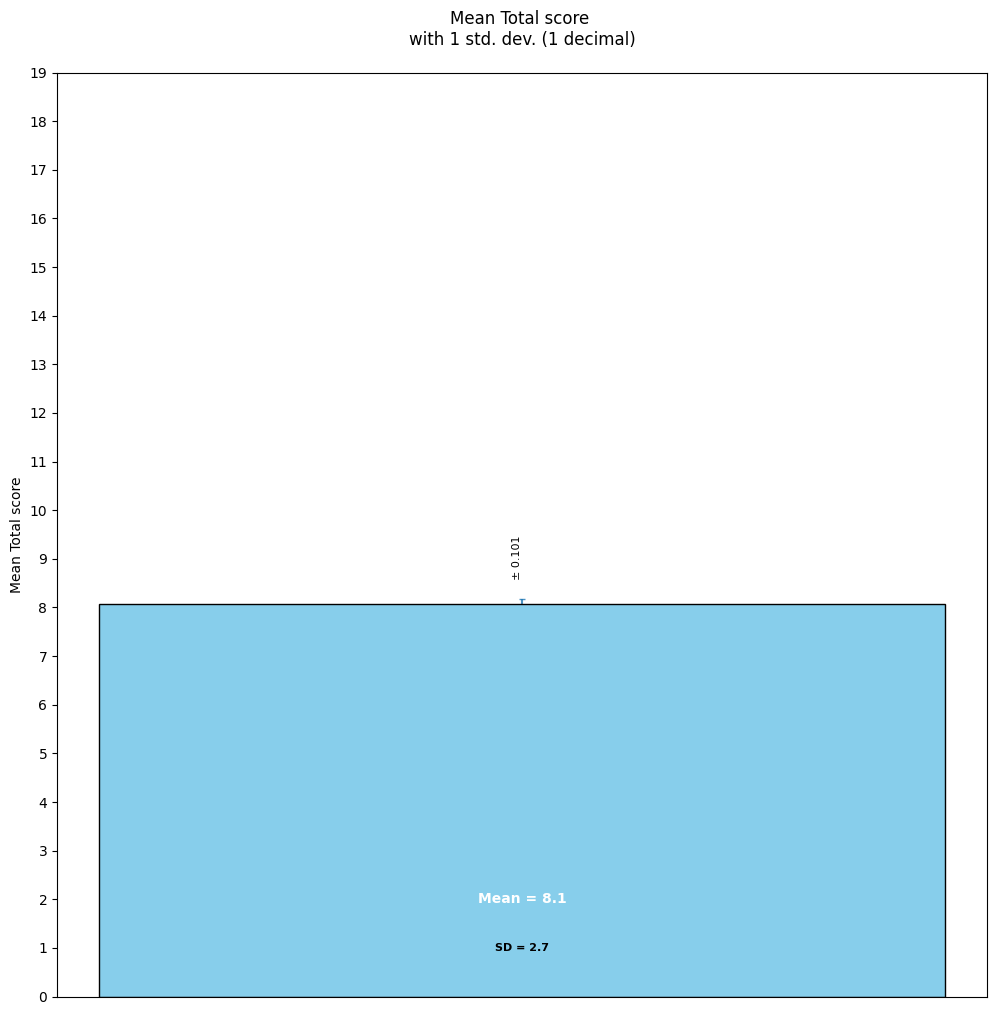

In [28]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean = main["TotalScore_19"].mean()
std = main["TotalScore_19"].std()
sem = main["TotalScore_19"].sem()

axes.bar(1, mean, width = 0.8, color="skyblue", edgecolor='black')
axes.errorbar(1, mean, yerr = sem,
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

axes.set_yticks(np.arange(0, 20))
axes.set_xticks(np.arange(0, 0))
axes.tick_params(axis = "x", rotation = 45)


axes.text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
axes.text(1, 2, f"Mean = {mean:.1f}", ha = "center", va = "center",
          color='white', fontsize=10, fontweight='bold')
axes.text(1, 1, f"SD = {std:.1f}", ha = "center", va = "center",
          color='black', fontsize=8, fontweight='bold')
    

axes.set_title("Mean Total score \nwith 1 std. dev. (1 decimal)", pad = 20)
axes.set_ylabel("Mean Total score")

----------------------------------

## Table 1.2 - Mean Facet Scores + SD (Ver. 1)

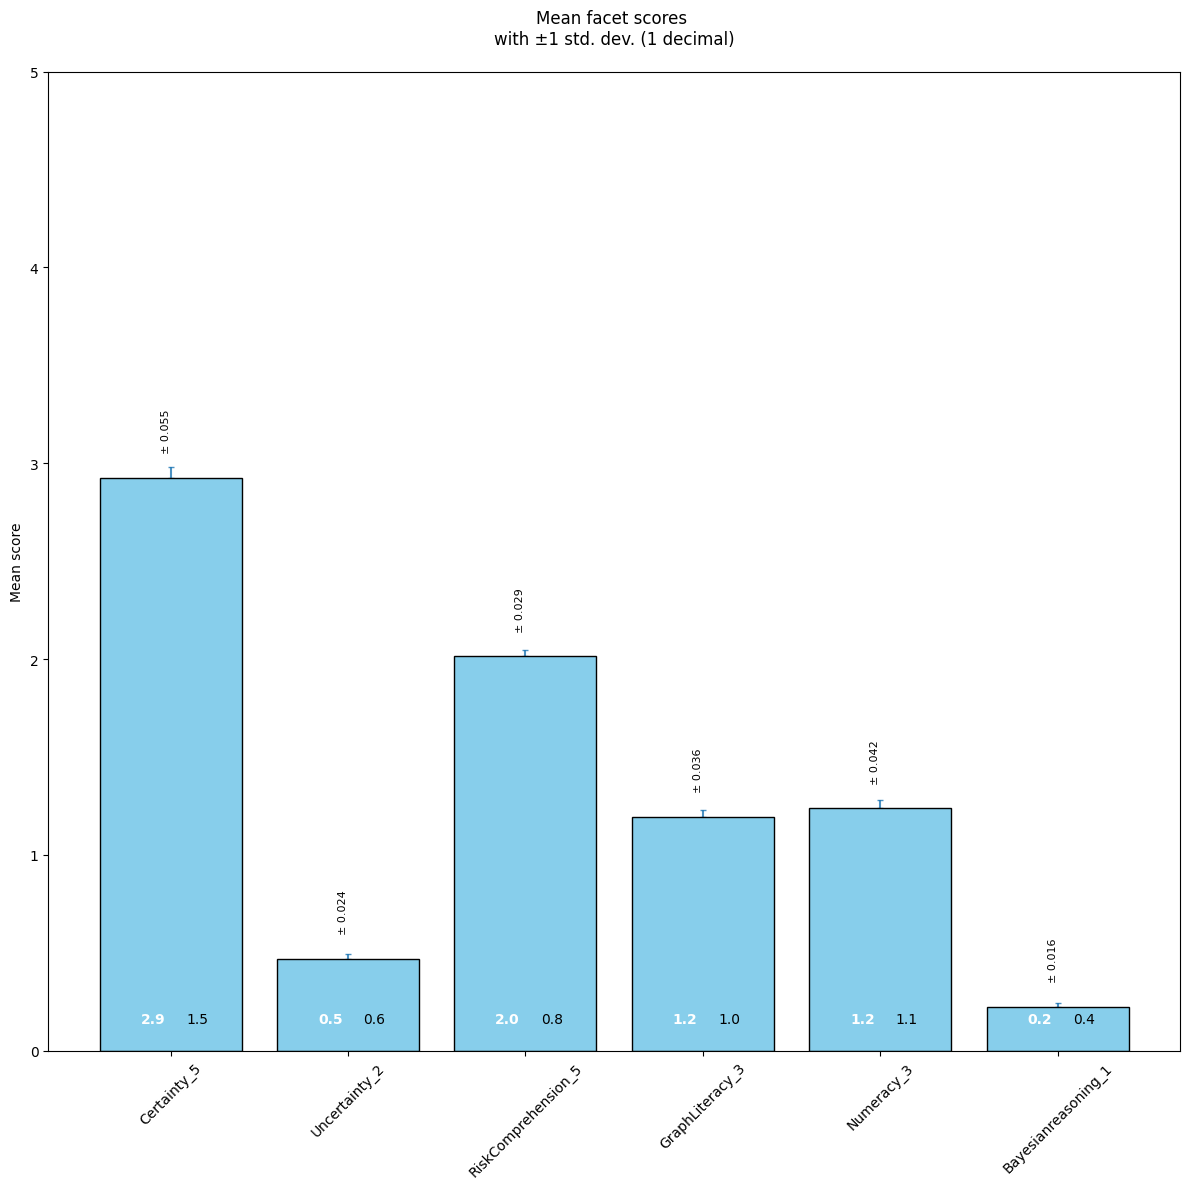

In [29]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean_scores = main[facet_cols].mean()
std_scores = main[facet_cols].std().reindex(mean_scores.index)
sem_scores = main[facet_cols].sem().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 5
axes.set_yticks(np.arange(0, y_max + 1))
axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j - 0.1, 0.025 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j + 0.15, 0.025 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10)

    

axes.set_title(f"Mean facet scores \nwith ±1 std. dev. (1 decimal)", pad = 20)
axes.set_ylabel(f"Mean score")


plt.tight_layout()
plt.show()

---

---

## Table 1.3 - M proportion of maximum (Total Score) score + SD + Median

Text(0, 0.5, 'Mean % score')

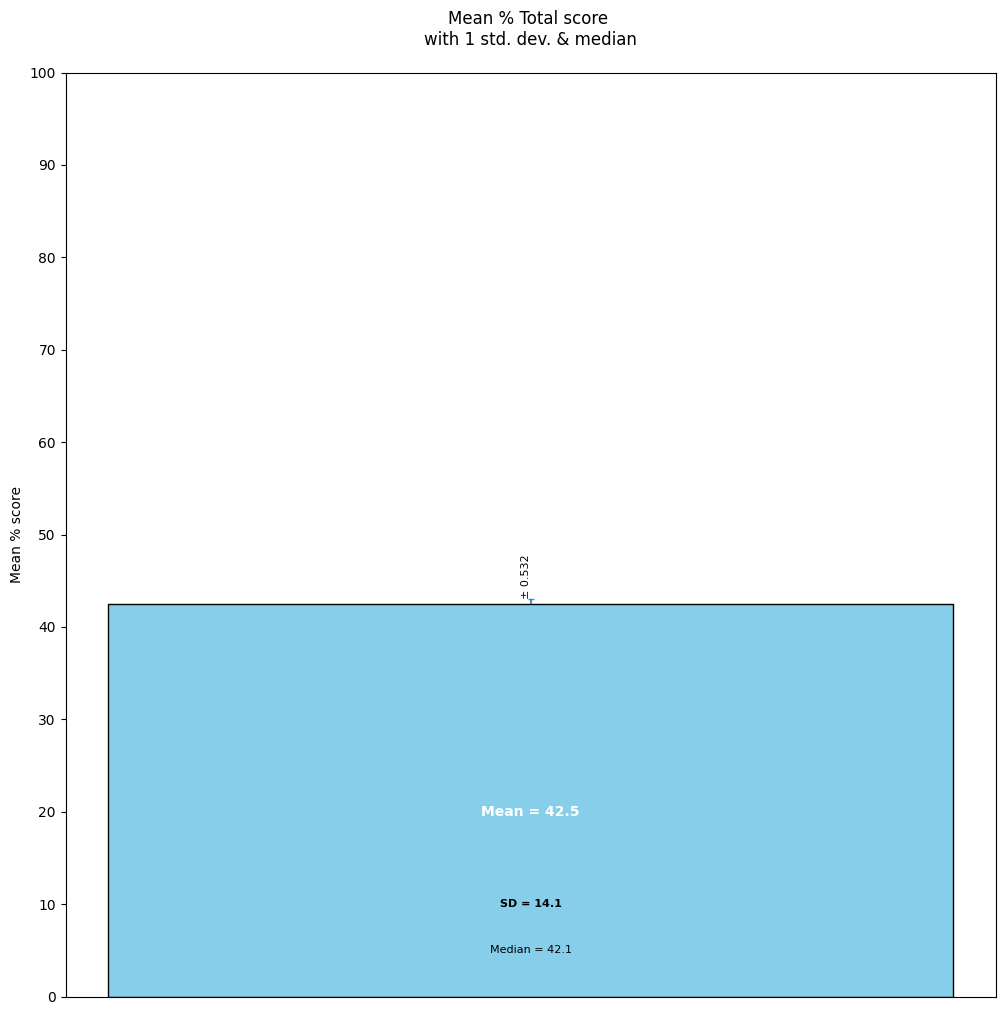

In [30]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean = main["TotalScore_%"].mean()
std =  main["TotalScore_%"].std()
sem =  main["TotalScore_%"].sem()
med =  main["TotalScore_%"].median()

axes.bar(1, mean, width = 0.8, color="skyblue", edgecolor='black')
axes.errorbar(1, mean, yerr = sem,
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

axes.set_yticks(np.arange(0, 101, step = 10))
axes.set_xticks(np.arange(0, 0))
axes.tick_params(axis = "x", rotation = 45)

axes.text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
axes.text(1, 20, f"Mean = {mean:.1f}", ha = "center", va = "center",
          color='white', fontsize=10, fontweight='bold')
axes.text(1, 10, f"SD = {std:.1f}", ha = "center", va = "center",
          color='black', fontsize=8, fontweight='bold')
axes.text(1, 5, f"Median = {med:.1f}", ha = "center", va = "center",
          color='black', fontsize=8)
    

axes.set_title("Mean % Total score \nwith 1 std. dev. & median", pad = 20)
axes.set_ylabel("Mean % score")

----------------------------------

## Table 1.4 - M proportion of Facet Scores + SD + Median

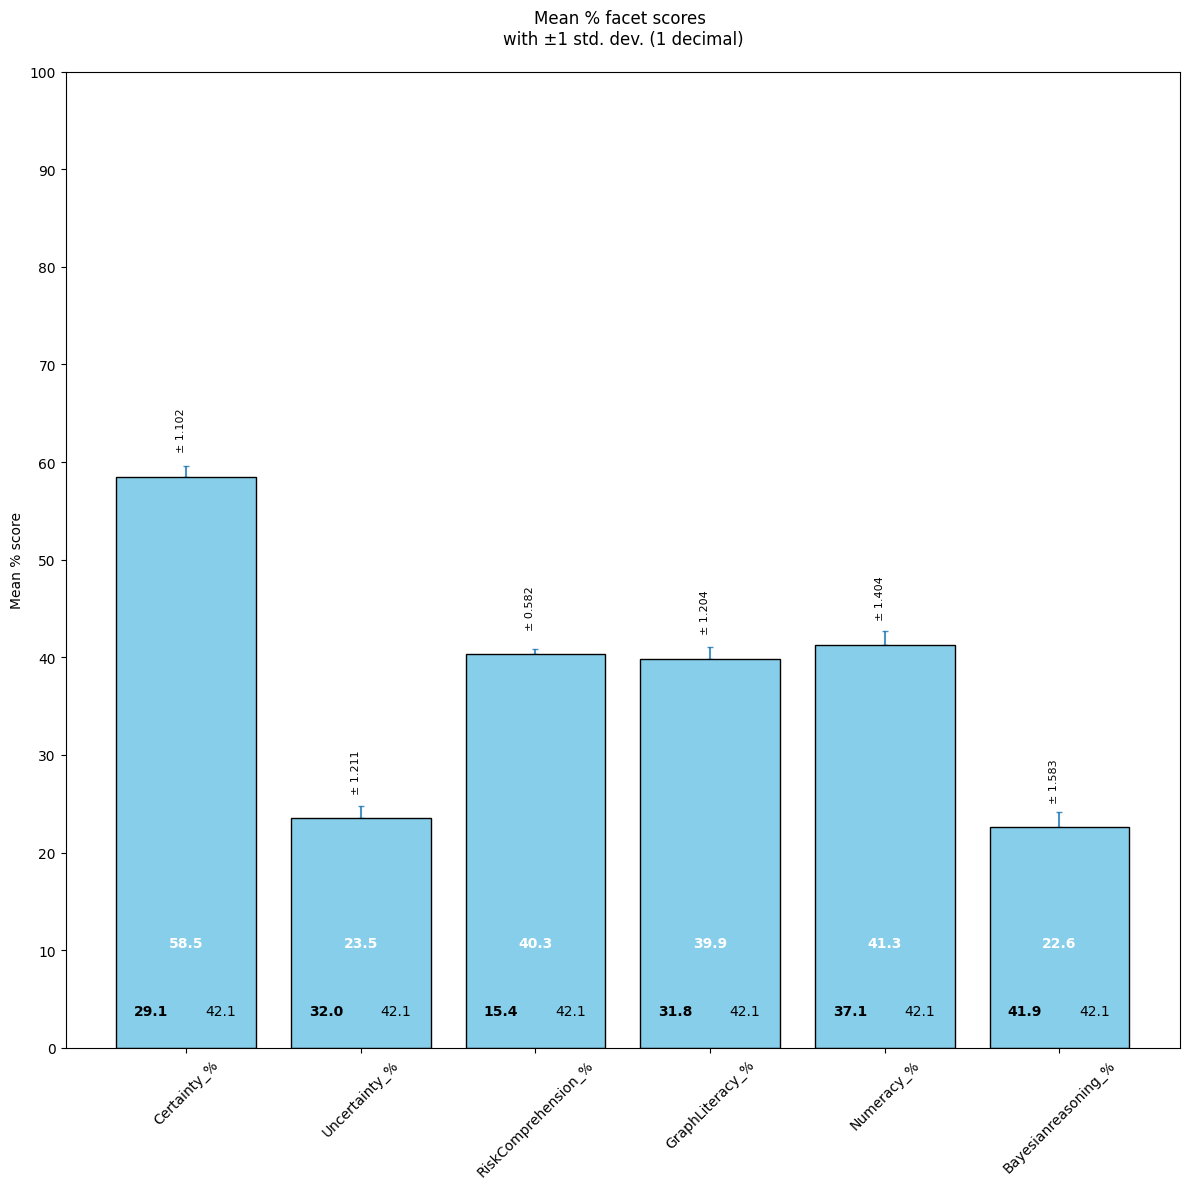

In [31]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean_scores = main[facet_percent_cols].mean()
std_scores = main[facet_percent_cols].std().reindex(mean_scores.index)
sem_scores = main[facet_percent_cols].sem().reindex(mean_scores.index)
med_scores = main[facet_percent_cols].median().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j - 0.2, 0.03 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10, fontweight='bold')
    axes.text(j + 0.2, 0.03 * y_max, f"{med:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=10)

    

axes.set_title(f"Mean % facet scores \nwith ±1 std. dev. (1 decimal)", pad = 20)
axes.set_ylabel(f"Mean % score")
plt.tight_layout()
plt.show()

---

---

## Table 2.1 - Per income class: Mean Facet Scores + SD + Median

Note: Income Class has been filtered out of entries who opted out of disclosing their income

In [32]:
income_filtered = main.loc[ ~(main["income"] == 0)].copy()
income_filtered.income.value_counts()

income
2    221
1    194
3    114
4     76
5     52
6     42
Name: count, dtype: int64

In [33]:
# fig, axes = plt.subplots(6, 1, figsize = [12, 6*6])

# income_classes = income_filtered.income.value_counts().sort_index().index.values

# for i, income_class in enumerate(income_classes):
#     sample = income_filtered.loc[ income_filtered["income"] == income_class].copy()
    
#     mean = sample["TotalScore_%"].mean()
#     std =  sample["TotalScore_%"].std()
#     sem =  sample["TotalScore_%"].sem()
#     med =  sample["TotalScore_%"].median()

#     axes[i].bar(1, mean, color="skyblue", edgecolor='black')
#     axes[i].errorbar(1, mean, yerr = [sem],
#                   fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

#     y_max = 100
#     axes[i].set_yticks(np.arange(0, 101, step = 20))
#     axes[i].tick_params(axis = "x", rotation = 45)
    
#     axes[i].text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
#     axes[i].text(1, 20, f"Mean = {mean:.1f}", ha = "center", va = "center",
#               color='white', fontsize=10, fontweight='bold')
#     axes[i].text(1, 10, f"SD = {std:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8, fontweight='bold')
#     axes[i].text(1, 5, f"Median = {med:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8)
        
    
#     axes[i].set_title(f"Mean % Total score \nfor income class :{income_class}", pad = 20)
#     axes[i].set_ylabel("Mean % Total score")

# plt.tight_layout()
# plt.show()

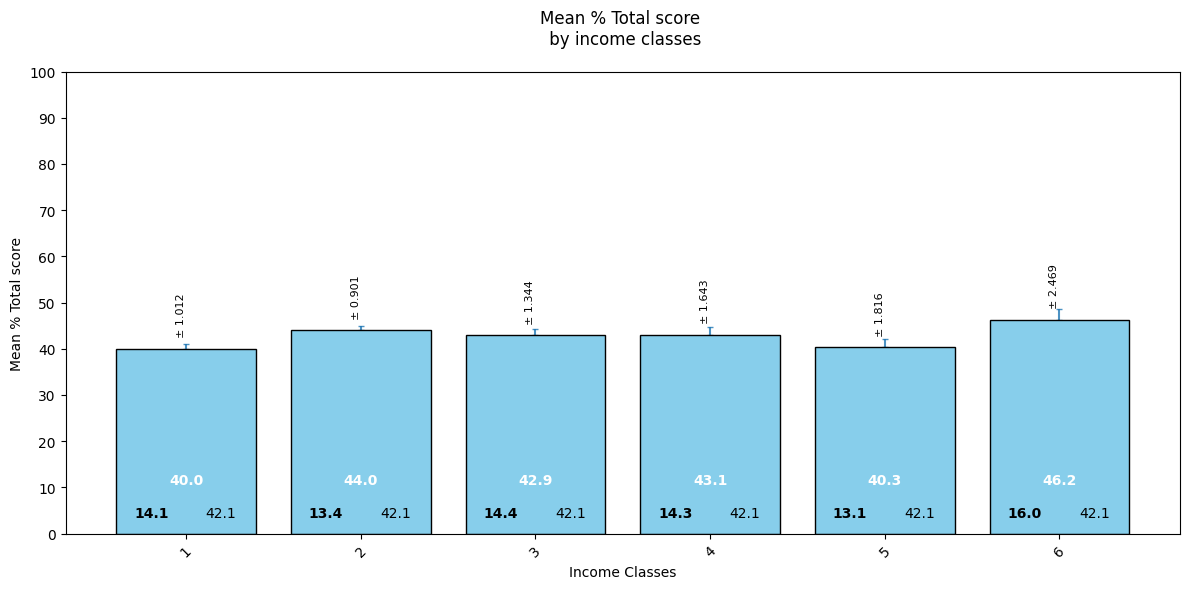

In [34]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

income_classes = income_filtered.income.value_counts().sort_index().index.values

sample = main.loc[ ~(main["income"] == 0)].copy()

mean_scores = sample.groupby("income")["TotalScore_%"].mean().sort_index()
std_scores =  sample.groupby("income")["TotalScore_%"].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("income")["TotalScore_%"].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("income")["TotalScore_%"].median().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j+1, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j+1, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j+1 - 0.2, 0.03 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10, fontweight='bold')
    axes.text(j+1 + 0.2, 0.03 * y_max, f"{med:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=10)
    

axes.set_title(f"Mean % Total score \n by income classes", pad = 20)
axes.set_ylabel("Mean % Total score")
axes.set_xlabel("Income Classes")

plt.tight_layout()
plt.show()

---

## Table 2.2 - Per income class: Mean Facet Scores

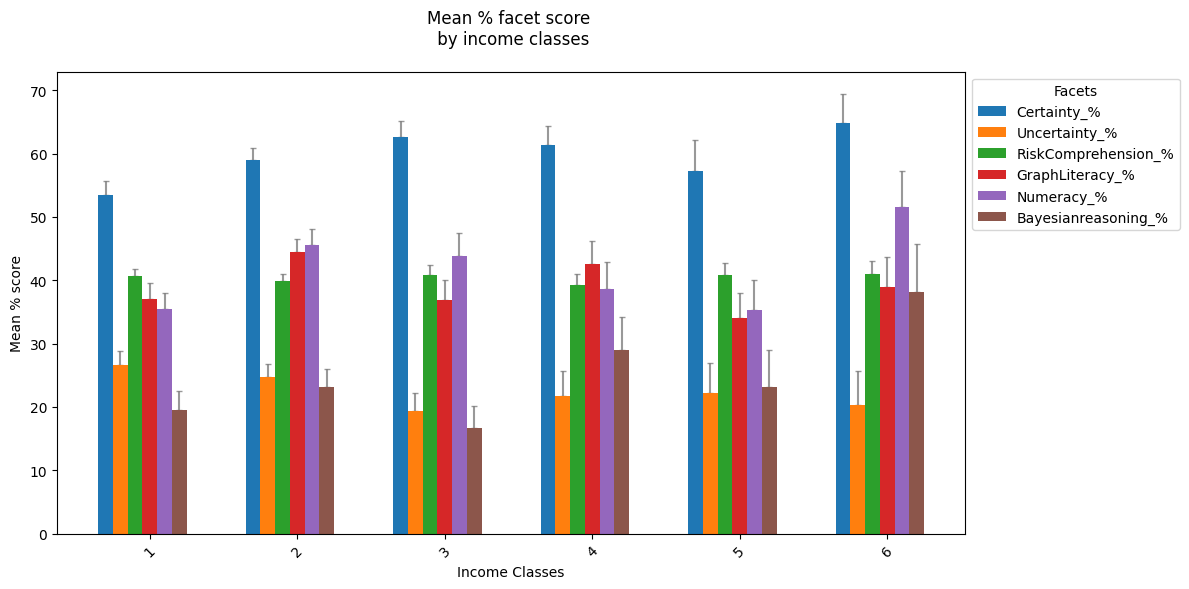

In [35]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

income_classes = income_filtered.income.value_counts().sort_index().index.values

sample = main.loc[ ~(main["income"] == 0)].copy()

mean_scores = sample.groupby("income")[facet_percent_cols].mean().sort_index()
std_scores =  sample.groupby("income")[facet_percent_cols].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("income")[facet_percent_cols].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("income")[facet_percent_cols].median().reindex(mean_scores.index)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

width = 0.1

for j, facet in enumerate(facet_percent_cols):
    mean_facet_scores = mean_scores[facet]
    sem_facet_scores = sem_scores[facet]

    offset = (- len(income_classes)/ 2 + j) * width
    axes.bar(income_classes + offset , mean_facet_scores, width, label = str(facet))
    axes.errorbar(income_classes + offset , mean_facet_scores, yerr = [np.zeros_like(sem_facet_scores), sem_facet_scores],
                  fmt = "none", capsize = 2.5, alpha = 0.8, zorder = 0, ecolor = "grey")


axes.set_title(f"Mean % facet score \n by income classes", pad = 20)
axes.set_ylabel("Mean % score")
axes.set_xlabel("Income Classes")
axes.legend(title="Facets", bbox_to_anchor=(1.0, 1))

plt.tight_layout()
plt.show()

---

---

## Table 3.1: (Countries pooled): Relationship to total sum score and controlling for education and age using income 

In [36]:
income_filtered = main.loc[ ~(main["income"] == 0)].copy()

risklit_quartile = pd.qcut(income_filtered["TotalScore_19"],q = 4, labels = False ) + 1
income_filtered["risklit_quartile"] = risklit_quartile.copy()

data = income_filtered.copy()

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

age_rec = [0] + sorted(data["age_rec"].unique())
age_dict = {0:"ALL Age", 2:"Only 18-35",
            3:"Only 36-55", 4:"Only 56+"}

In [37]:
# # fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# # axes = axes.flatten()

# for i, age_class in enumerate(age_rec):
#     if age_class == 0:
#         sample = data.copy()
#     else:
#         sample = data.loc[ data["age_rec"] == age_class].copy()
#     sample_ready = sample.groupby("risklit_quartile")["income"].value_counts().to_frame().sort_index()
#     sample_ready = sample_ready.unstack(level = "income")
#     sample_ready.columns = sample_ready.columns.droplevel(0)
#     sample_ready.plot(kind='bar', stacked=True)

#     plt.ylabel("count each risk literacy quartile")
#     plt.xlabel("Risk quartile")
#     plt.title(f"Stacked bar chart: {age_dict[age_class]}")
#     plt.legend(title="Income class", bbox_to_anchor=(1, 1))
    
# plt.show()

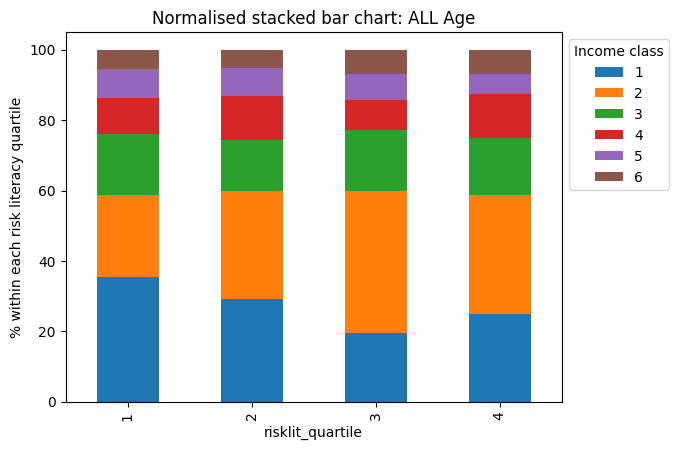

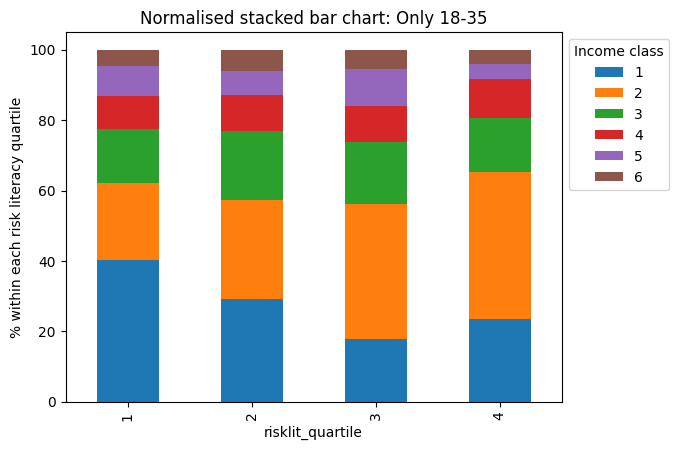

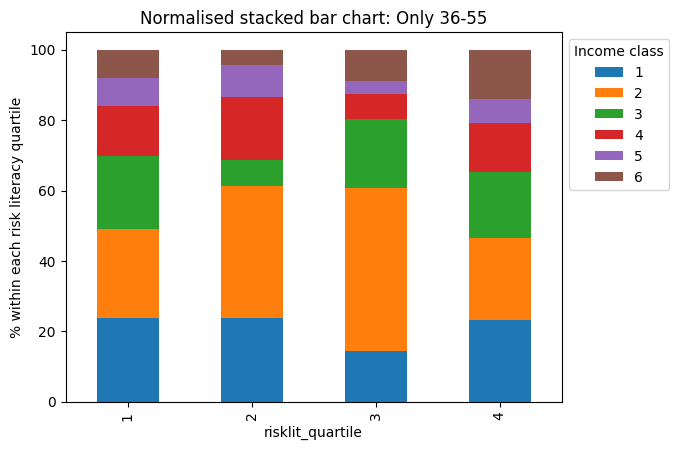

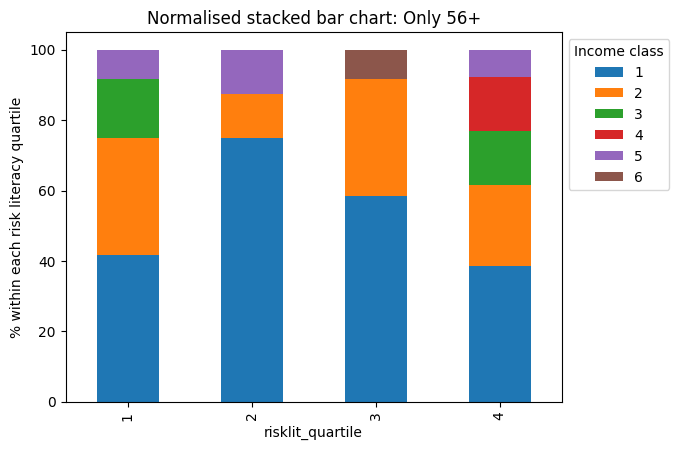

In [38]:
# fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# axes = axes.flatten()

for i, age_class in enumerate(age_rec):
    if age_class == 0:
        sample = data.copy()
    else:
        sample = data.loc[ data["age_rec"] == age_class].copy()
    sample_ready = sample.groupby("risklit_quartile")["income"].value_counts().to_frame().sort_index()
    sample_ready = sample_ready.unstack(level = "income")
    sample_ready.columns = sample_ready.columns.droplevel(0)
    sample_ready = sample_ready.div(sample_ready.sum(axis = 1), axis = 0)*100
    sample_ready.plot(kind='bar', stacked=True)

    plt.ylabel("% within each risk literacy quartile")
    plt.title(f"Normalised stacked bar chart: {age_dict[age_class]}")
    plt.legend(title="Income class", bbox_to_anchor=(1, 1))
    
plt.show()

---

---

---

---

## Table 4.1 - Per country per wealth quartile: M proportion of maximum score + SD + Median facet scores

Note: Wealth Class has been filtered out of entries who opted out of disclosing their income, and a quartile on the resulting data has been created

In [39]:
wealth_filtered = main.loc[ ~(pd.isnull(main["wealth"]))].copy().reset_index()
wealth_quartile = pd.qcut(wealth_filtered["wealth"],q = 4, labels = False, duplicates = "raise") + 1
wealth_filtered["wealth_quartile"] = wealth_quartile.copy()

In [40]:
# fig, axes = plt.subplots(4, 1, figsize = [12, 6*4])

# wealth_quartiles = sorted(wealth_filtered["wealth_quartile"].unique())

# for i, wealth_quartile in enumerate(wealth_quartiles):
#     sample = wealth_filtered.loc[ wealth_filtered["wealth_quartile"] == wealth_quartile].copy()
    
#     mean = sample["TotalScore_%"].mean()
#     std =  sample["TotalScore_%"].std()
#     sem =  sample["TotalScore_%"].sem()
#     med =  sample["TotalScore_%"].median()

#     axes[i].bar(1, mean, color="skyblue", edgecolor='black')
#     axes[i].errorbar(1, mean, yerr = sem,
#                   fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

#     y_max = 100
#     axes[i].set_yticks(np.arange(0, 101, step = 20))
#     axes[i].tick_params(axis = "x", rotation = 45)
    
#     axes[i].text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
#     axes[i].text(1, 20, f"Mean = {mean:.1f}", ha = "center", va = "center",
#               color='white', fontsize=10, fontweight='bold')
#     axes[i].text(1, 10, f"SD = {std:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8, fontweight='bold')
#     axes[i].text(1, 5, f"Median = {med:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8)
        
    
#     axes[i].set_title(f"Mean % Total score \nfor wealth quartile :Q{wealth_quartile}", pad = 20)
#     axes[i].set_ylabel("Mean % Total score")

# plt.tight_layout()
# plt.show()

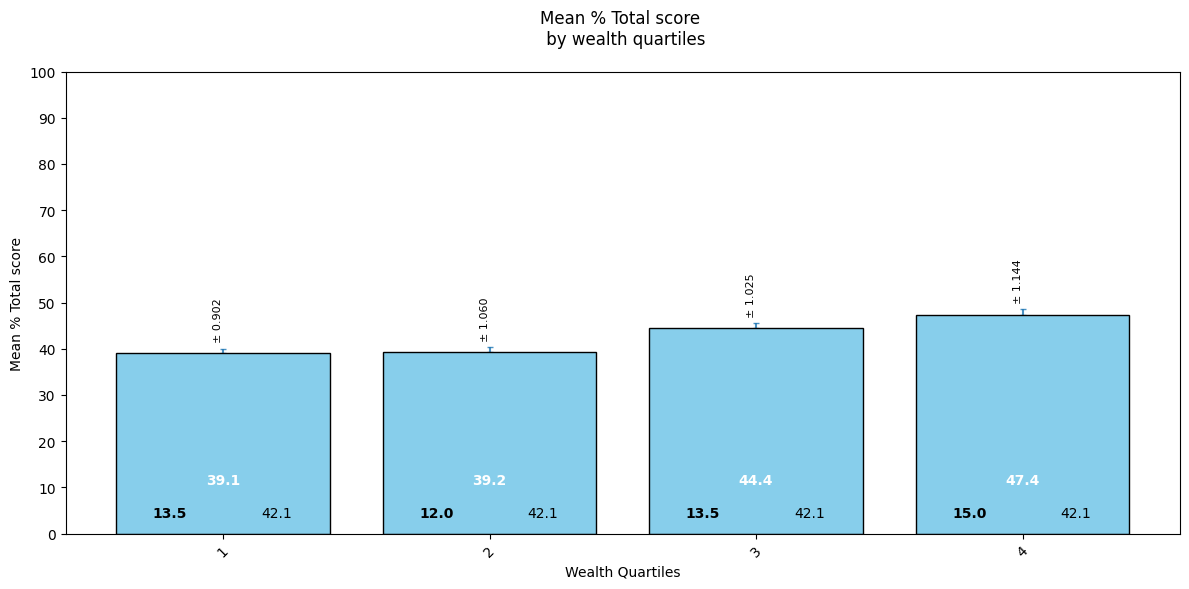

In [41]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

sample = wealth_filtered.copy()
wealth_quartiles = sorted(wealth_filtered["wealth_quartile"].unique())

mean_scores = sample.groupby("wealth_quartile")["TotalScore_%"].mean().sort_index()
std_scores =  sample.groupby("wealth_quartile")["TotalScore_%"].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("wealth_quartile")["TotalScore_%"].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("wealth_quartile")["TotalScore_%"].median().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.set_xticks(np.arange(1, 5, step = 1))

axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j+1, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j+1, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j+1 - 0.2, 0.03 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10, fontweight='bold')
    axes.text(j+1 + 0.2, 0.03 * y_max, f"{med:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=10)
    

axes.set_title(f"Mean % Total score \n by wealth quartiles", pad = 20)
axes.set_ylabel("Mean % Total score")
axes.set_xlabel("Wealth Quartiles")

plt.tight_layout()
plt.show()


---

## Table 2.2 - Per wealth class: Mean Facet Scores

In [42]:
income_classes

array([1, 2, 3, 4, 5, 6])

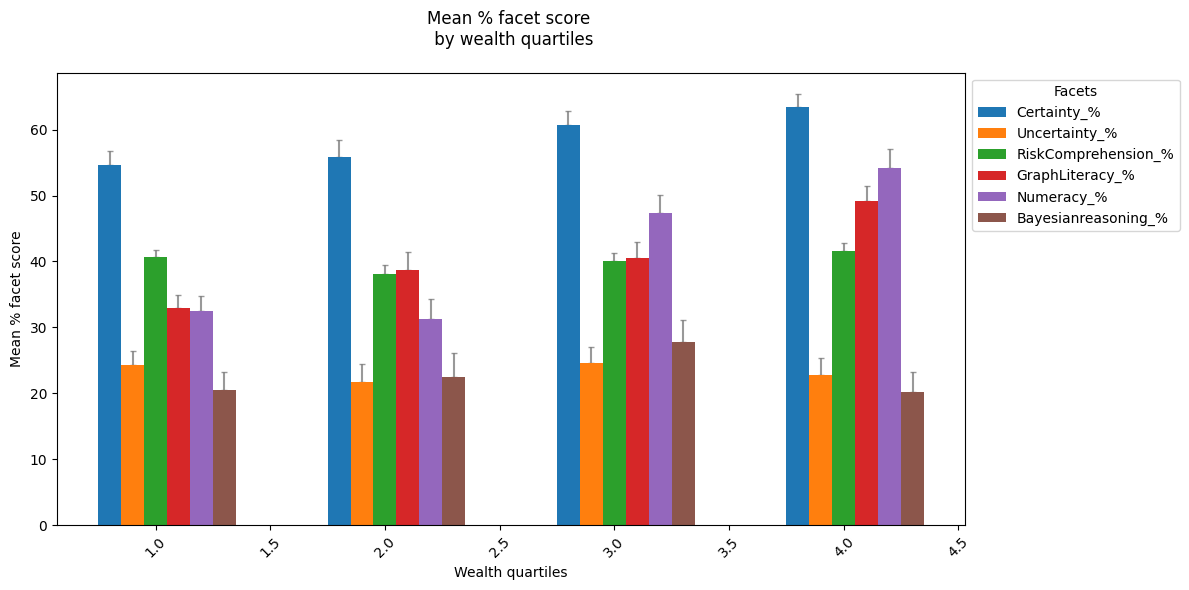

In [43]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

sample = wealth_filtered.copy()
wealth_quartiles = np.array(sorted(wealth_filtered["wealth_quartile"].unique()))

mean_scores = sample.groupby("wealth_quartile")[facet_percent_cols].mean().sort_index()
std_scores =  sample.groupby("wealth_quartile")[facet_percent_cols].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("wealth_quartile")[facet_percent_cols].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("wealth_quartile")[facet_percent_cols].median().reindex(mean_scores.index)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

width = 0.1

for j, facet in enumerate(facet_percent_cols):
    mean_facet_scores = mean_scores[facet]
    sem_facet_scores = sem_scores[facet]

    offset = (- len(wealth_quartiles)/ 2 + j) * width
    axes.bar(wealth_quartiles + offset , mean_facet_scores, width, label = str(facet))
    axes.errorbar(wealth_quartiles + offset , mean_facet_scores, yerr = [np.zeros_like(sem_facet_scores), sem_facet_scores],
                  fmt = "none", capsize = 2.5, alpha = 0.8, zorder = 0, ecolor = "grey")


axes.set_title(f"Mean % facet score \n by wealth quartiles", pad = 20)
axes.set_ylabel("Mean % facet score")
axes.set_xlabel("Wealth quartiles")
axes.legend(title="Facets", bbox_to_anchor=(1.0, 1))

plt.tight_layout()
plt.show()

---

## Table 5.1: (Countries pooled): Relationship to total sum score and controlling for education and age using income 

In [44]:
wealth_filtered = main.loc[ ~(main["wealth"] == -1)].copy().reset_index()
wealth_quartile = pd.qcut(wealth_filtered["wealth"],q = 4, labels = False, duplicates = "raise") + 1
wealth_filtered["wealth_quartile"] = wealth_quartile.copy()

In [45]:
wealth_filtered = main.loc[ ~(main["wealth"] == -1)].copy().reset_index()
wealth_quartile = pd.qcut(wealth_filtered["wealth"],q = 4, labels = False, duplicates = "raise") + 1
wealth_filtered["wealth_quartile"] = wealth_quartile.copy()

risklit_quartile = pd.qcut(wealth_filtered["TotalScore_19"],q = 4, labels = False ) + 1
wealth_filtered["risklit_quartile"] = risklit_quartile.copy()

data = wealth_filtered.copy()

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

age_rec = [0] + sorted(data["age_rec"].unique())
age_dict = {0:"ALL Age", 2:"Only 18-35",
            3:"Only 36-55", 4:"Only 56+"}

In [46]:
# # fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# # axes = axes.flatten()

# for i, age_class in enumerate(age_rec):
#     if age_class == 0:
#         sample = data.copy()
#     else:
#         sample = data.loc[ data["age_rec"] == age_class].copy()
#     sample_ready = sample.groupby("risklit_quartile")["wealth_quartile"].value_counts().to_frame().sort_index()
#     sample_ready = sample_ready.unstack(level = "wealth_quartile")
#     sample_ready.columns = sample_ready.columns.droplevel(0)
#     sample_ready.plot(kind='bar', stacked=True)

#     plt.ylabel("count each risk literacy quartile")
#     plt.xlabel("Risk quartile")
#     plt.title(f"Stacked bar chart: {age_dict[age_class]}")
#     plt.legend(title="Wealth quartiles", bbox_to_anchor=(1, 1))
    
# plt.show()

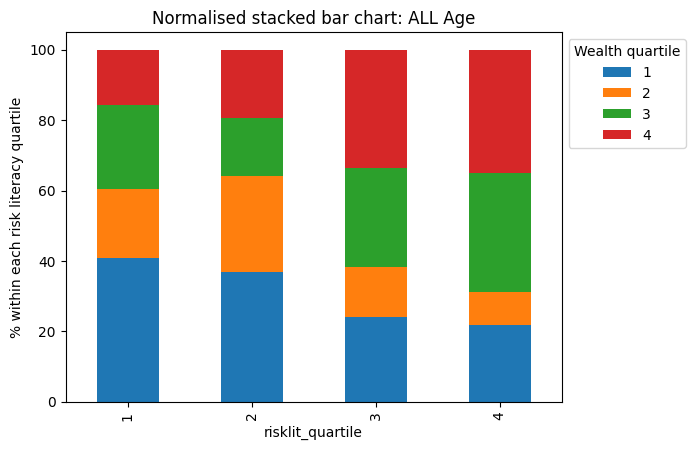

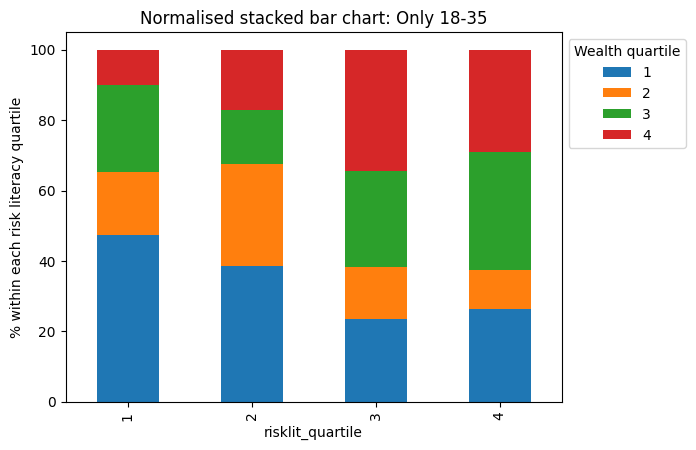

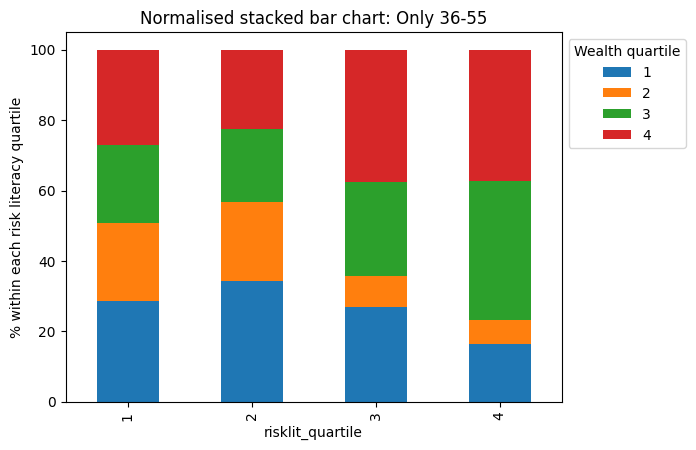

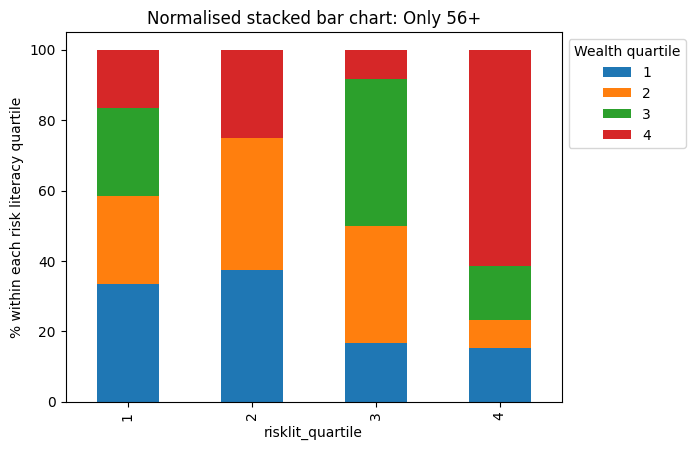

In [47]:
# fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# axes = axes.flatten()

for i, age_class in enumerate(age_rec):
    if age_class == 0:
        sample = data.copy()
    else:
        sample = data.loc[ data["age_rec"] == age_class].copy()
    sample_ready = sample.groupby("risklit_quartile")["wealth_quartile"].value_counts().to_frame().sort_index()
    sample_ready = sample_ready.unstack(level = "wealth_quartile")
    sample_ready.columns = sample_ready.columns.droplevel(0)
    sample_ready = sample_ready.div(sample_ready.sum(axis = 1), axis = 0)*100
    sample_ready.plot(kind='bar', stacked=True)

    plt.ylabel("% within each risk literacy quartile")
    plt.title(f"Normalised stacked bar chart: {age_dict[age_class]}")
    plt.legend(title="Wealth quartile", bbox_to_anchor=(1, 1))
    
plt.show()

---

---

---

---

## Ordinal Logistic Regression: Income Class by Risk literacy

### V1: Without any control variables

In [48]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.617684
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -1130.8
Model:                   OrderedModel   AIC:                             2274.
Method:            Maximum Likelihood   BIC:                             2301.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:11                                         
No. Observations:                 699                                         
Df Residuals:                     693                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: With control of education

In [49]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.548681
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -1082.5
Model:                   OrderedModel   AIC:                             2179.
Method:            Maximum Likelihood   BIC:                             2211.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:11                                         
No. Observations:                 699                                         
Df Residuals:                     692                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: With control of education and age

In [50]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "age_rec"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.548598
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -1082.5
Model:                   OrderedModel   AIC:                             2181.
Method:            Maximum Likelihood   BIC:                             2217.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:11                                         
No. Observations:                 699                                         
Df Residuals:                     691                                         
Df Model:                           3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V4: With control of education and age and financial literacy

In [51]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.545540
         Iterations: 31
         Function evaluations: 37
         Gradient evaluations: 37
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -1080.3
Model:                   OrderedModel   AIC:                             2179.
Method:            Maximum Likelihood   BIC:                             2220.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:12                                         
No. Observations:                 699                                         
Df Residuals:                     690                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V5: With control of education, age , financial literacy, CRT

In [52]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.534191
         Iterations: 34
         Function evaluations: 37
         Gradient evaluations: 37
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -1072.4
Model:                   OrderedModel   AIC:                             2165.
Method:            Maximum Likelihood   BIC:                             2210.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:12                                         
No. Observations:                 699                                         
Df Residuals:                     689                                         
Df Model:                           5                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

## Ordinal Logistic Regression: Income Class by Risk literacy FOR 36-55 years old

### V1: without control of education

In [53]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.653741
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -378.71
Model:                   OrderedModel   AIC:                             769.4
Method:            Maximum Likelihood   BIC:                             790.0
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:12                                         
No. Observations:                 229                                         
Df Residuals:                     223                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: with control of education

In [54]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.605316
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -367.62
Model:                   OrderedModel   AIC:                             749.2
Method:            Maximum Likelihood   BIC:                             773.3
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:12                                         
No. Observations:                 229                                         
Df Residuals:                     222                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: with control of education and financial literacy

In [55]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "FinancialLiteracy_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.574854
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -360.64
Model:                   OrderedModel   AIC:                             737.3
Method:            Maximum Likelihood   BIC:                             764.8
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:12                                         
No. Observations:                 229                                         
Df Residuals:                     221                                         
Df Model:                           3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V4: with control of education, financial literacy, CRT

In [56]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.558355
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -356.86
Model:                   OrderedModel   AIC:                             731.7
Method:            Maximum Likelihood   BIC:                             762.6
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:12                                         
No. Observations:                 229                                         
Df Residuals:                     220                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

---

## Ordinal Logistic Regression: Income Terciles by Risk literacy

### V1: Without any control variables

In [57]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.049694
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -733.74
Model:                   OrderedModel   AIC:                             1473.
Method:            Maximum Likelihood   BIC:                             1487.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:12                                         
No. Observations:                 699                                         
Df Residuals:                     696                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

### V2: With control of education

In [58]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.991388
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -692.98
Model:                   OrderedModel   AIC:                             1394.
Method:            Maximum Likelihood   BIC:                             1412.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:12                                         
No. Observations:                 699                                         
Df Residuals:                     695                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: With control of education and age

In [59]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced", "age_rec"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.991374
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -692.97
Model:                   OrderedModel   AIC:                             1396.
Method:            Maximum Likelihood   BIC:                             1419.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:12                                         
No. Observations:                 699                                         
Df Residuals:                     694                                         
Df Model:                           3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V4: With control of education and age and financial literacy

In [60]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.989298
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -691.52
Model:                   OrderedModel   AIC:                             1395.
Method:            Maximum Likelihood   BIC:                             1422.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:12                                         
No. Observations:                 699                                         
Df Residuals:                     693                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V5: With control of education, age, financial literacy, CRT

In [61]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.979006
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -684.32
Model:                   OrderedModel   AIC:                             1383.
Method:            Maximum Likelihood   BIC:                             1414.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:13                                         
No. Observations:                 699                                         
Df Residuals:                     692                                         
Df Model:                           5                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

## Ordinal Logistic Regression: Income Tercile by Risk literacy FOR 36-55 years old

### V1: without control of education

In [62]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.035575
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -237.15
Model:                   OrderedModel   AIC:                             480.3
Method:            Maximum Likelihood   BIC:                             490.6
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:13                                         
No. Observations:                 229                                         
Df Residuals:                     226                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: with control of education

In [63]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.990439
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -226.81
Model:                   OrderedModel   AIC:                             461.6
Method:            Maximum Likelihood   BIC:                             475.4
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:13                                         
No. Observations:                 229                                         
Df Residuals:                     225                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: with control of education and financial literacy

In [64]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced", "FinancialLiteracy_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.965049
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -221.00
Model:                   OrderedModel   AIC:                             452.0
Method:            Maximum Likelihood   BIC:                             469.2
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:13                                         
No. Observations:                 229                                         
Df Residuals:                     224                                         
Df Model:                           3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V4: with control of education,  financial literacy, CRT

In [65]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.951083
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -217.80
Model:                   OrderedModel   AIC:                             447.6
Method:            Maximum Likelihood   BIC:                             468.2
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:13                                         
No. Observations:                 229                                         
Df Residuals:                     223                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

---

## Ordinal Logistic Regression: Income Quartiles by Risk literacy

### V1: Without any control variables

In [66]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.342402
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -938.34
Model:                   OrderedModel   AIC:                             1885.
Method:            Maximum Likelihood   BIC:                             1903.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:13                                         
No. Observations:                 699                                         
Df Residuals:                     695                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: With control of education

In [67]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.272766
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -889.66
Model:                   OrderedModel   AIC:                             1789.
Method:            Maximum Likelihood   BIC:                             1812.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:13                                         
No. Observations:                 699                                         
Df Residuals:                     694                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: With control of education and age

In [68]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data[["risklit_quartile", "isced", "age_rec"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.272614
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -889.56
Model:                   OrderedModel   AIC:                             1791.
Method:            Maximum Likelihood   BIC:                             1818.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:13                                         
No. Observations:                 699                                         
Df Residuals:                     693                                         
Df Model:                           3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V4: With control of education and age and financial literacy

In [69]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.269377
         Iterations: 22
         Function evaluations: 28
         Gradient evaluations: 28
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -887.29
Model:                   OrderedModel   AIC:                             1789.
Method:            Maximum Likelihood   BIC:                             1820.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:13                                         
No. Observations:                 699                                         
Df Residuals:                     692                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V5: With control of education, age, financial literacy, CRT

In [70]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.259140
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -880.14
Model:                   OrderedModel   AIC:                             1776.
Method:            Maximum Likelihood   BIC:                             1813.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:13                                         
No. Observations:                 699                                         
Df Residuals:                     691                                         
Df Model:                           5                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

## Ordinal Logistic Regression: Income Quartile by Risk literacy FOR 36-55 years old

### V1: without control of education

In [71]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.343650
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -307.70
Model:                   OrderedModel   AIC:                             623.4
Method:            Maximum Likelihood   BIC:                             637.1
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:13                                         
No. Observations:                 229                                         
Df Residuals:                     225                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: with control of education

In [72]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.295431
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -296.65
Model:                   OrderedModel   AIC:                             603.3
Method:            Maximum Likelihood   BIC:                             620.5
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:13                                         
No. Observations:                 229                                         
Df Residuals:                     224                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: with control of education and financial literacy

In [73]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data[["risklit_quartile", "isced", "FinancialLiteracy_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.266146
         Iterations: 19
         Function evaluations: 22
         Gradient evaluations: 22
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -289.95
Model:                   OrderedModel   AIC:                             591.9
Method:            Maximum Likelihood   BIC:                             612.5
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:14                                         
No. Observations:                 229                                         
Df Residuals:                     223                                         
Df Model:                           3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V4: with control of education, financial literacy, CRT

In [74]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data[["risklit_quartile", "isced", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.250303
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -286.32
Model:                   OrderedModel   AIC:                             586.6
Method:            Maximum Likelihood   BIC:                             610.7
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:14                                         
No. Observations:                 229                                         
Df Residuals:                     222                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

---

## Ordinal Logistic Regression: Wealth Quartiles by Risk literacy

### V1: Without any control variables

In [75]:
main

,responseid,country_text,country,age,gender_text,age_rec,isced,income,wealth,Certainty_5,Uncertainty_2,RiskComprehension_5,GraphLiteracy_3,Numeracy_3,Bayesianreasoning_1,Certainty_%,Uncertainty_%,RiskComprehension_%,GraphLiteracy_%,Numeracy_%,Bayesianreasoning_%,TotalScore_19,TotalScore_%,RiskAssets_%,SafeAssets_%,RiskAlignment,RiskAlignment_residual,RiskAlignment_felix,RiskAppetite1_%,RiskAppetite_7,RiskAppetite2_%,InvestmentXP_4,FinancialPlanning1_6,FinancialPlanning2_6,FinancialPlanning1_%,FinancialPlanning2_%,FinancialLiteracy_%,FinancialLiteracy_3,CRTScore_3,CRTScore_%,certainty1,certainty2,certainty3,certainty4,certainty5,uncertainty1,uncertainty2,numeracy1,numeracy2,numeracy3,graph1,graph2,graph3,riskcomprehension1,riskcomprehension2,riskcomprehension3,riskcomprehension4,riskcomprehension5,bayesian1,financialplanning_1,financialplanning_2,financialplanning_3,financialplanning_4,financialplanning_5,financialplanning_6,financialplanning_emergency,financialplanning_retirement,savings_bank,fixed_deposits,recurring_deposits,gov_bonds,corp_bonds,mutual_funds,stocks,real_estate,commodities,other_invest,savings_bank_dummy,gov_bonds_dummy,mutual_funds_dummy,stocks_dummy,investment_behaviour,risky_investments,investments,income_tercile,income_quartile,wealth_quartile,risklit_quartile_income,risklit_quartile_wealth
0,0,India,0,30.0,Male,2,1,2,5000000.0,2.0,0.0,1.0,2.0,1.0,1.0,40.0,0.0,20.0,66.666667,33.333333,100.0,7.0,36.842105,50.0,50.0,71.428571,-21.428571,3.50,71.428571,5.0,75.0,3.0,5.500000,5.500,91.666667,91.666667,66.666667,2.0,1.0,33.333333,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,5,5,5,6,6,6,5,6,25.0,15.0,10.0,0.0,0.0,15.0,15.0,15.0,5.0,0.0,1,0,1,1,3,50.0,50.0,2,2,4,2,2
1,1,India,0,53.0,Male,3,1,4,9000000.0,4.0,0.0,2.0,1.0,0.0,1.0,80.0,0.0,40.0,33.333333,0.000000,100.0,8.0,42.105263,80.0,20.0,71.428571,8.571429,5.60,71.428571,5.0,50.0,2.0,3.833333,4.125,63.888889,68.750000,100.000000,3.0,1.0,33.333333,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,4,2,2,5,5,5,4,6,10.0,10.0,0.0,0.0,0.0,10.0,0.0,40.0,20.0,10.0,1,0,1,0,2,80.0,80.0,3,3,4,2,2
2,2,India,0,43.0,Male,3,2,1,2200000.0,4.0,1.0,3.0,3.0,2.0,0.0,80.0,50.0,60.0,100.000000,66.666667,0.0,13.0,68.421053,0.0,100.0,85.714286,-85.714286,0.00,85.714286,6.0,50.0,2.0,4.666667,4.625,77.777778,77.083333,66.666667,2.0,0.0,0.000000,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,5,4,5,4,5,5,5,4,80.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0.0,0.0,1,1,3,4,4
3,3,India,0,32.0,Male,2,2,3,8000000.0,4.0,0.0,1.0,1.0,3.0,0.0,80.0,0.0,20.0,33.333333,100.000000,0.0,9.0,47.368421,75.0,25.0,100.000000,-25.000000,5.25,100.000000,7.0,100.0,4.0,5.500000,5.625,91.666667,93.750000,100.000000,3.0,0.0,0.000000,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6,5,5,6,6,5,6,6,10.0,5.0,5.0,5.0,0.0,40.0,5.0,0.0,20.0,10.0,1,1,1,1,4,75.0,80.0,2,3,4,3,3
4,4,India,0,31.0,Female,2,1,3,35000000.0,3.0,1.0,2.0,1.0,1.0,0.0,60.0,50.0,40.0,33.333333,33.333333,0.0,8.0,42.105263,34.0,66.0,85.714286,-51.714286,2.38,85.714286,6.0,100.0,4.0,5.000000,5.000,83.333333,83.333333,33.333333,1.0,0.0,0.000000,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4,5,4,5,6,6,5,5,20.0,25.0,5.0,10.0,6.0,5.0,5.0,15.0,9.0,0.0,1,1,1,1,4,34.0,50.0,2,3,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,694,India,0,44.0,Female,3,1,2,5000000.0,4.0,2.0,4.0,2.0,2.0,0.0,80.0,100.0,80.0,66.666667,66.666667,0.0,14.0,73.684211,75.0,25.0,42.857143,32.142857,5.25,42.857143,3.0,50.0,2.0,3.833333,4.125,63.888889,68.750000,100.000000,3.0,1.0,33.333333,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,

In [76]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# data = wealth_filtered.copy()
data = main.loc[ main["wealth"] > 100000].copy().reset_index()

wealth_quartile = pd.qcut(data["wealth"],q = 4, labels = False, duplicates = "raise") + 1
data["wealth_quartile"] = wealth_quartile

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

risklit_quartile = pd.qcut(data["TotalScore_19"],q = 4, labels = False ) + 1
data["risklit_quartile"] = risklit_quartile.copy()

model = OrderedModel(data["wealth_quartile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.359329
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -645.68
Model:                   OrderedModel   AIC:                             1299.
Method:            Maximum Likelihood   BIC:                             1316.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:14                                         
No. Observations:                 475                                         
Df Residuals:                     471                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: With control of education

In [77]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.305237
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -912.36
Model:                   OrderedModel   AIC:                             1835.
Method:            Maximum Likelihood   BIC:                             1857.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:14                                         
No. Observations:                 699                                         
Df Residuals:                     694                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: With control of education and age

In [78]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "age_rec"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.298779
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -907.85
Model:                   OrderedModel   AIC:                             1828.
Method:            Maximum Likelihood   BIC:                             1855.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:14                                         
No. Observations:                 699                                         
Df Residuals:                     693                                         
Df Model:                           3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V4: With control of education, age and Financial Lit

In [79]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.286741
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -899.43
Model:                   OrderedModel   AIC:                             1813.
Method:            Maximum Likelihood   BIC:                             1845.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:14                                         
No. Observations:                 699                                         
Df Residuals:                     692                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V5: With control of education, age, Financial Lit, CRT

In [80]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.286279
         Iterations: 26
         Function evaluations: 31
         Gradient evaluations: 31
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -899.11
Model:                   OrderedModel   AIC:                             1814.
Method:            Maximum Likelihood   BIC:                             1851.
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:14                                         
No. Observations:                 699                                         
Df Residuals:                     691                                         
Df Model:                           5                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

## Ordinal Logistic Regression: Wealth Quartiles by Risk literacy FOR 36-55 years old

### V1: without control of education

In [81]:
data = wealth_filtered.loc[wealth_filtered["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.348215
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -308.74
Model:                   OrderedModel   AIC:                             625.5
Method:            Maximum Likelihood   BIC:                             639.2
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:14                                         
No. Observations:                 229                                         
Df Residuals:                     225                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: with control of education

In [82]:
data = wealth_filtered.loc[wealth_filtered["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.288747
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -295.12
Model:                   OrderedModel   AIC:                             600.2
Method:            Maximum Likelihood   BIC:                             617.4
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:14                                         
No. Observations:                 229                                         
Df Residuals:                     224                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: with control of education and financial literacy

In [83]:
data = wealth_filtered.loc[wealth_filtered["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "FinancialLiteracy_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.273174
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -291.56
Model:                   OrderedModel   AIC:                             595.1
Method:            Maximum Likelihood   BIC:                             615.7
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:15                                         
No. Observations:                 229                                         
Df Residuals:                     223                                         
Df Model:                           3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V4: with control of education, financial literacy, CRT

In [84]:
data = wealth_filtered.loc[wealth_filtered["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.272834
         Iterations: 23
         Function evaluations: 29
         Gradient evaluations: 29
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -291.48
Model:                   OrderedModel   AIC:                             597.0
Method:            Maximum Likelihood   BIC:                             621.0
Date:                Fri, 25 Jul 2025                                         
Time:                        11:35:15                                         
No. Observations:                 229                                         
Df Residuals:                     222                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

## WITH CONSTANT

## Linear Regression: Financial Planning 1 by Risk literacy

In [85]:
finplan1_data = main.copy()
risklit_quartile = pd.qcut(finplan1_data["TotalScore_19"],q = 4, labels = False ) + 1
finplan1_data["risklit_quartile"] = risklit_quartile.copy()

### V1: Without any control variables

In [86]:
import statsmodels.api as sm

data = finplan1_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data["risklit_quartile"]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.004
Model:                              OLS   Adj. R-squared:                  0.002
Method:                   Least Squares   F-statistic:                     2.667
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):              0.103
Time:                          11:35:15   Log-Likelihood:                -2916.5
No. Observations:                   699   AIC:                             5837.
Df Residuals:                       697   BIC:                             5846.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

### V2: With control of education

In [87]:
import statsmodels.api as sm

data = finplan1_data.copy()


model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data[["risklit_quartile", "isced"]]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.043
Model:                              OLS   Adj. R-squared:                  0.041
Method:                   Least Squares   F-statistic:                     15.80
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):           1.95e-07
Time:                          11:35:15   Log-Likelihood:                -2902.3
No. Observations:                   699   AIC:                             5811.
Df Residuals:                       696   BIC:                             5824.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

### V3: With control of education and age

In [88]:
import statsmodels.api as sm

data = finplan1_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data[["risklit_quartile", "isced", "age_rec"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.047
Model:                              OLS   Adj. R-squared:                  0.043
Method:                   Least Squares   F-statistic:                     11.51
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):           2.27e-07
Time:                          11:35:15   Log-Likelihood:                -2900.9
No. Observations:                   699   AIC:                             5810.
Df Residuals:                       695   BIC:                             5828.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

### V4: With control of education, age and Financial Lit

In [89]:
import statsmodels.api as sm

data = finplan1_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.048
Model:                              OLS   Adj. R-squared:                  0.042
Method:                   Least Squares   F-statistic:                     8.734
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):           6.99e-07
Time:                          11:35:15   Log-Likelihood:                -2900.7
No. Observations:                   699   AIC:                             5811.
Df Residuals:                       694   BIC:                             5834.
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const         

### V5: With control of education, age, Financial Lit, CRT

In [90]:
import statsmodels.api as sm

data = finplan1_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.048
Model:                              OLS   Adj. R-squared:                  0.041
Method:                   Least Squares   F-statistic:                     6.990
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):           2.20e-06
Time:                          11:35:15   Log-Likelihood:                -2900.6
No. Observations:                   699   AIC:                             5813.
Df Residuals:                       693   BIC:                             5841.
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const         

---

## Linear Regression: Financial Planning 1 by Risk literacy FOR 36-55 years old

### V1: without control of education

In [91]:
data = finplan1_data.loc[finplan1_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data["risklit_quartile"]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.005
Model:                              OLS   Adj. R-squared:                  0.001
Method:                   Least Squares   F-statistic:                     1.159
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):              0.283
Time:                          11:35:15   Log-Likelihood:                -945.86
No. Observations:                   229   AIC:                             1896.
Df Residuals:                       227   BIC:                             1903.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

### V2: with control of education

In [92]:
data = finplan1_data.loc[finplan1_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data[["risklit_quartile", "isced"]]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.043
Model:                              OLS   Adj. R-squared:                  0.034
Method:                   Least Squares   F-statistic:                     5.026
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):            0.00732
Time:                          11:35:15   Log-Likelihood:                -941.46
No. Observations:                   229   AIC:                             1889.
Df Residuals:                       226   BIC:                             1899.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

### V3: with control of education and financial literacy

In [93]:
data = finplan1_data.loc[finplan1_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data[["risklit_quartile", "isced", "FinancialLiteracy_%"]]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.078
Model:                              OLS   Adj. R-squared:                  0.066
Method:                   Least Squares   F-statistic:                     6.328
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):           0.000388
Time:                          11:35:15   Log-Likelihood:                -937.17
No. Observations:                   229   AIC:                             1882.
Df Residuals:                       225   BIC:                             1896.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const         

### V4: with control of education, financial literacy, CRT

In [94]:
data = finplan1_data.loc[finplan1_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data[["risklit_quartile", "isced", "FinancialLiteracy_%", "CRTScore_%"]]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.078
Model:                              OLS   Adj. R-squared:                  0.062
Method:                   Least Squares   F-statistic:                     4.747
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):            0.00107
Time:                          11:35:15   Log-Likelihood:                -937.13
No. Observations:                   229   AIC:                             1884.
Df Residuals:                       224   BIC:                             1901.
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const         

---

## Linear Regression: Financial Planning 2 by Risk literacy

In [95]:
finplan2_data = main.copy()
risklit_quartile = pd.qcut(finplan2_data["TotalScore_19"],q = 4, labels = False ) + 1
finplan2_data["risklit_quartile"] = risklit_quartile.copy()

### V1: Without any control variables

In [96]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data["risklit_quartile"]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.004
Model:                              OLS   Adj. R-squared:                  0.002
Method:                   Least Squares   F-statistic:                     2.667
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):              0.103
Time:                          11:35:15   Log-Likelihood:                -2916.5
No. Observations:                   699   AIC:                             5837.
Df Residuals:                       697   BIC:                             5846.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

### V2: With control of education

In [97]:
import statsmodels.api as sm

data = finplan2_data.copy()


model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data[["risklit_quartile", "isced"]]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.043
Model:                              OLS   Adj. R-squared:                  0.041
Method:                   Least Squares   F-statistic:                     15.80
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):           1.95e-07
Time:                          11:35:15   Log-Likelihood:                -2902.3
No. Observations:                   699   AIC:                             5811.
Df Residuals:                       696   BIC:                             5824.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

### V3: With control of education and age

In [98]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data[["risklit_quartile", "isced", "age_rec"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.047
Model:                              OLS   Adj. R-squared:                  0.043
Method:                   Least Squares   F-statistic:                     11.51
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):           2.27e-07
Time:                          11:35:15   Log-Likelihood:                -2900.9
No. Observations:                   699   AIC:                             5810.
Df Residuals:                       695   BIC:                             5828.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

### V4: With control of education, age and Financial Lit

In [99]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.048
Model:                              OLS   Adj. R-squared:                  0.042
Method:                   Least Squares   F-statistic:                     8.734
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):           6.99e-07
Time:                          11:35:15   Log-Likelihood:                -2900.7
No. Observations:                   699   AIC:                             5811.
Df Residuals:                       694   BIC:                             5834.
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const         

### V5: With control of education, age, Financial Lit, CRT

In [100]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.048
Model:                              OLS   Adj. R-squared:                  0.041
Method:                   Least Squares   F-statistic:                     6.990
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):           2.20e-06
Time:                          11:35:15   Log-Likelihood:                -2900.6
No. Observations:                   699   AIC:                             5813.
Df Residuals:                       693   BIC:                             5841.
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const         

---

## Linear Regression: Financial Planning 2 by Risk literacy FOR 36-55 years old

### V1: without control of education

In [101]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data["risklit_quartile"]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.005
Model:                              OLS   Adj. R-squared:                  0.001
Method:                   Least Squares   F-statistic:                     1.159
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):              0.283
Time:                          11:35:15   Log-Likelihood:                -945.86
No. Observations:                   229   AIC:                             1896.
Df Residuals:                       227   BIC:                             1903.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

### V2: with control of education

In [102]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data[["risklit_quartile", "isced"]]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.043
Model:                              OLS   Adj. R-squared:                  0.034
Method:                   Least Squares   F-statistic:                     5.026
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):            0.00732
Time:                          11:35:15   Log-Likelihood:                -941.46
No. Observations:                   229   AIC:                             1889.
Df Residuals:                       226   BIC:                             1899.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

### V3: with control of education and financial literacy

In [103]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data[["risklit_quartile", "isced", "FinancialLiteracy_%"]]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.078
Model:                              OLS   Adj. R-squared:                  0.066
Method:                   Least Squares   F-statistic:                     6.328
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):           0.000388
Time:                          11:35:15   Log-Likelihood:                -937.17
No. Observations:                   229   AIC:                             1882.
Df Residuals:                       225   BIC:                             1896.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const         

### V4: with control of education, financial literacy, CRT

In [104]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], sm.add_constant(data[["risklit_quartile", "isced", "FinancialLiteracy_%", "CRTScore_%"]]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     FinancialPlanning1_%   R-squared:                       0.078
Model:                              OLS   Adj. R-squared:                  0.062
Method:                   Least Squares   F-statistic:                     4.747
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):            0.00107
Time:                          11:35:15   Log-Likelihood:                -937.13
No. Observations:                   229   AIC:                             1884.
Df Residuals:                       224   BIC:                             1901.
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const         

---

---

## WITHOUT CONSTANT

## Linear Regression: Financial Planning 1 by Risk literacy

In [105]:
finplan1_data = wealth_filtered.copy()
risklit_quartile = pd.qcut(finplan1_data["TotalScore_19"],q = 4, labels = False ) + 1
finplan1_data["risklit_quartile"] = risklit_quartile.copy()




In [106]:
cols = ["savings_bank", "gov_bonds", "mutual_funds", "stocks"]
[col + "_dummy" for col in cols]


['savings_bank_dummy', 'gov_bonds_dummy', 'mutual_funds_dummy', 'stocks_dummy']

In [107]:
finplan1_data

,index,responseid,country_text,country,age,gender_text,age_rec,isced,income,wealth,Certainty_5,Uncertainty_2,RiskComprehension_5,GraphLiteracy_3,Numeracy_3,Bayesianreasoning_1,Certainty_%,Uncertainty_%,RiskComprehension_%,GraphLiteracy_%,Numeracy_%,Bayesianreasoning_%,TotalScore_19,TotalScore_%,RiskAssets_%,SafeAssets_%,RiskAlignment,RiskAlignment_residual,RiskAlignment_felix,RiskAppetite1_%,RiskAppetite_7,RiskAppetite2_%,InvestmentXP_4,FinancialPlanning1_6,FinancialPlanning2_6,FinancialPlanning1_%,FinancialPlanning2_%,FinancialLiteracy_%,FinancialLiteracy_3,CRTScore_3,CRTScore_%,certainty1,certainty2,certainty3,certainty4,certainty5,uncertainty1,uncertainty2,numeracy1,numeracy2,numeracy3,graph1,graph2,graph3,riskcomprehension1,riskcomprehension2,riskcomprehension3,riskcomprehension4,riskcomprehension5,bayesian1,financialplanning_1,financialplanning_2,financialplanning_3,financialplanning_4,financialplanning_5,financialplanning_6,financialplanning_emergency,financialplanning_retirement,savings_bank,fixed_deposits,recurring_deposits,gov_bonds,corp_bonds,mutual_funds,stocks,real_estate,commodities,other_invest,savings_bank_dummy,gov_bonds_dummy,mutual_funds_dummy,stocks_dummy,investment_behaviour,risky_investments,investments,income_tercile,income_quartile,wealth_quartile,risklit_quartile_income,risklit_quartile_wealth,risklit_quartile
0,0,0,India,0,30.0,Male,2,1,2,5000000.0,2.0,0.0,1.0,2.0,1.0,1.0,40.0,0.0,20.0,66.666667,33.333333,100.0,7.0,36.842105,50.0,50.0,71.428571,-21.428571,3.50,71.428571,5.0,75.0,3.0,5.500000,5.500,91.666667,91.666667,66.666667,2.0,1.0,33.333333,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,5,5,5,6,6,6,5,6,25.0,15.0,10.0,0.0,0.0,15.0,15.0,15.0,5.0,0.0,1,0,1,1,3,50.0,50.0,2,2,4,2,2,2
1,1,1,India,0,53.0,Male,3,1,4,9000000.0,4.0,0.0,2.0,1.0,0.0,1.0,80.0,0.0,40.0,33.333333,0.000000,100.0,8.0,42.105263,80.0,20.0,71.428571,8.571429,5.60,71.428571,5.0,50.0,2.0,3.833333,4.125,63.888889,68.750000,100.000000,3.0,1.0,33.333333,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,4,2,2,5,5,5,4,6,10.0,10.0,0.0,0.0,0.0,10.0,0.0,40.0,20.0,10.0,1,0,1,0,2,80.0,80.0,3,3,4,2,2,2
2,2,2,India,0,43.0,Male,3,2,1,2200000.0,4.0,1.0,3.0,3.0,2.0,0.0,80.0,50.0,60.0,100.000000,66.666667,0.0,13.0,68.421053,0.0,100.0,85.714286,-85.714286,0.00,85.714286,6.0,50.0,2.0,4.666667,4.625,77.777778,77.083333,66.666667,2.0,0.0,0.000000,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,5,4,5,4,5,5,5,4,80.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0.0,0.0,1,1,3,4,4,4
3,3,3,India,0,32.0,Male,2,2,3,8000000.0,4.0,0.0,1.0,1.0,3.0,0.0,80.0,0.0,20.0,33.333333,100.000000,0.0,9.0,47.368421,75.0,25.0,100.000000,-25.000000,5.25,100.000000,7.0,100.0,4.0,5.500000,5.625,91.666667,93.750000,100.000000,3.0,0.0,0.000000,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6,5,5,6,6,5,6,6,10.0,5.0,5.0,5.0,0.0,40.0,5.0,0.0,20.0,10.0,1,1,1,1,4,75.0,80.0,2,3,4,3,3,3
4,4,4,India,0,31.0,Female,2,1,3,35000000.0,3.0,1.0,2.0,1.0,1.0,0.0,60.0,50.0,40.0,33.333333,33.333333,0.0,8.0,42.105263,34.0,66.0,85.714286,-51.714286,2.38,85.714286,6.0,100.0,4.0,5.000000,5.000,83.333333,83.333333,33.333333,1.0,0.0,0.000000,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4,5,4,5,6,6,5,5,20.0,25.0,5.0,10.0,6.0,5.0,5.0,15.0,9.0,0.0,1,1,1,1,4,34.0,50.0,2,3,4,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,694,694,India,0,44.0,Female,3,1,2,5000000.0,4.0,2.0,4.0,2.0,2.0,0.0,80.0,100.0,80.0,66.666667,66.666667,0.0,14.0,73.684211,75.0,25.0,42.857143,32.142857,5.25,42.857143,3.0,50.0,2.0,3.833333,4.125,63.888889,68.750000,100.000000,3.0

### V1: Without any control variables

In [108]:
import statsmodels.api as sm

data = finplan1_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], data["risklit_quartile"])

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.798
Model:                              OLS   Adj. R-squared (uncentered):              0.798
Method:                   Least Squares   F-statistic:                              2758.
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                   1.23e-244
Time:                          11:35:15   Log-Likelihood:                         -3477.5
No. Observations:                   699   AIC:                                      6957.
Df Residuals:                       698   BIC:                                      6961.
Df Model:                             1                                                  
Covariance Type:              nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------

### V2: With control of education

In [109]:
import statsmodels.api as sm

data = finplan1_data.copy()


model = sm.OLS(data["FinancialPlanning1_%"], data[["risklit_quartile", "isced"]])

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.875
Model:                              OLS   Adj. R-squared (uncentered):              0.874
Method:                   Least Squares   F-statistic:                              2435.
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                   3.30e-315
Time:                          11:35:15   Log-Likelihood:                         -3310.3
No. Observations:                   699   AIC:                                      6625.
Df Residuals:                       697   BIC:                                      6634.
Df Model:                             2                                                  
Covariance Type:              nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------

### V3: With control of education and age

In [110]:
import statsmodels.api as sm

data = finplan1_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], data[["risklit_quartile", "isced", "age_rec"]])

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.923
Model:                              OLS   Adj. R-squared (uncentered):              0.923
Method:                   Least Squares   F-statistic:                              2777.
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                        0.00
Time:                          11:35:15   Log-Likelihood:                         -3140.8
No. Observations:                   699   AIC:                                      6288.
Df Residuals:                       696   BIC:                                      6301.
Df Model:                             3                                                  
Covariance Type:              nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------

### V4: With control of education, age and Financial Lit

In [111]:
import statsmodels.api as sm

data = finplan1_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]])

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.923
Model:                              OLS   Adj. R-squared (uncentered):              0.923
Method:                   Least Squares   F-statistic:                              2083.
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                        0.00
Time:                          11:35:15   Log-Likelihood:                         -3140.3
No. Observations:                   699   AIC:                                      6289.
Df Residuals:                       695   BIC:                                      6307.
Df Model:                             4                                                  
Covariance Type:              nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
------------

### V5: With control of education, age, Financial Lit, CRT

In [112]:
import statsmodels.api as sm

data = finplan1_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]])

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.923
Model:                              OLS   Adj. R-squared (uncentered):              0.922
Method:                   Least Squares   F-statistic:                              1664.
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                        0.00
Time:                          11:35:15   Log-Likelihood:                         -3140.3
No. Observations:                   699   AIC:                                      6291.
Df Residuals:                       694   BIC:                                      6313.
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
------------

---

## Linear Regression: Financial Planning 1 by Risk literacy FOR 36-55 years old

### V1: without control of education

In [113]:
data = finplan1_data.loc[finplan1_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], data["risklit_quartile"])

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.807
Model:                              OLS   Adj. R-squared (uncentered):              0.806
Method:                   Least Squares   F-statistic:                              953.8
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                    2.01e-83
Time:                          11:35:15   Log-Likelihood:                         -1138.4
No. Observations:                   229   AIC:                                      2279.
Df Residuals:                       228   BIC:                                      2282.
Df Model:                             1                                                  
Covariance Type:              nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------

### V2: with control of education

In [114]:
data = finplan1_data.loc[finplan1_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], data[["risklit_quartile", "isced"]])

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.895
Model:                              OLS   Adj. R-squared (uncentered):              0.894
Method:                   Least Squares   F-statistic:                              964.0
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                   1.15e-111
Time:                          11:35:15   Log-Likelihood:                         -1069.1
No. Observations:                   229   AIC:                                      2142.
Df Residuals:                       227   BIC:                                      2149.
Df Model:                             2                                                  
Covariance Type:              nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------

### V3: with control of education and financial literacy

In [115]:
data = finplan1_data.loc[finplan1_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], data[["risklit_quartile", "isced", "FinancialLiteracy_%"]])

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.896
Model:                              OLS   Adj. R-squared (uncentered):              0.895
Method:                   Least Squares   F-statistic:                              650.4
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                   7.77e-111
Time:                          11:35:15   Log-Likelihood:                         -1067.4
No. Observations:                   229   AIC:                                      2141.
Df Residuals:                       226   BIC:                                      2151.
Df Model:                             3                                                  
Covariance Type:              nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
------------

### V4: with control of education, financial literacy, CRT

In [116]:
data = finplan1_data.loc[finplan1_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], data[["risklit_quartile", "isced", "FinancialLiteracy_%", "CRTScore_%"]])

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.896
Model:                              OLS   Adj. R-squared (uncentered):              0.894
Method:                   Least Squares   F-statistic:                              485.8
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                   2.08e-109
Time:                          11:35:16   Log-Likelihood:                         -1067.4
No. Observations:                   229   AIC:                                      2143.
Df Residuals:                       225   BIC:                                      2156.
Df Model:                             4                                                  
Covariance Type:              nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
------------

---

## Linear Regression: Financial Planning 2 by Risk literacy

In [117]:
finplan2_data = main.copy()
risklit_quartile = pd.qcut(finplan2_data["TotalScore_19"],q = 4, labels = False ) + 1
finplan2_data["risklit_quartile"] = risklit_quartile.copy()

### V1: Without any control variables

In [118]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], data["risklit_quartile"])

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.798
Model:                              OLS   Adj. R-squared (uncentered):              0.798
Method:                   Least Squares   F-statistic:                              2758.
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                   1.23e-244
Time:                          11:35:16   Log-Likelihood:                         -3477.5
No. Observations:                   699   AIC:                                      6957.
Df Residuals:                       698   BIC:                                      6961.
Df Model:                             1                                                  
Covariance Type:              nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------

### V2: With control of education

In [119]:
import statsmodels.api as sm

data = finplan2_data.copy()


model = sm.OLS(data["FinancialPlanning1_%"], data[["risklit_quartile", "isced"]])

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.875
Model:                              OLS   Adj. R-squared (uncentered):              0.874
Method:                   Least Squares   F-statistic:                              2435.
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                   3.30e-315
Time:                          11:35:16   Log-Likelihood:                         -3310.3
No. Observations:                   699   AIC:                                      6625.
Df Residuals:                       697   BIC:                                      6634.
Df Model:                             2                                                  
Covariance Type:              nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------

### V3: With control of education and age

In [120]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], data[["risklit_quartile", "isced", "age_rec"]])

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.923
Model:                              OLS   Adj. R-squared (uncentered):              0.923
Method:                   Least Squares   F-statistic:                              2777.
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                        0.00
Time:                          11:35:16   Log-Likelihood:                         -3140.8
No. Observations:                   699   AIC:                                      6288.
Df Residuals:                       696   BIC:                                      6301.
Df Model:                             3                                                  
Covariance Type:              nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------

### V4: With control of education, age and Financial Lit

In [121]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]])

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.923
Model:                              OLS   Adj. R-squared (uncentered):              0.923
Method:                   Least Squares   F-statistic:                              2083.
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                        0.00
Time:                          11:35:16   Log-Likelihood:                         -3140.3
No. Observations:                   699   AIC:                                      6289.
Df Residuals:                       695   BIC:                                      6307.
Df Model:                             4                                                  
Covariance Type:              nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
------------

### V5: With control of education, age, Financial Lit, CRT

In [122]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["FinancialPlanning1_%"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]])

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.923
Model:                              OLS   Adj. R-squared (uncentered):              0.922
Method:                   Least Squares   F-statistic:                              1664.
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                        0.00
Time:                          11:35:16   Log-Likelihood:                         -3140.3
No. Observations:                   699   AIC:                                      6291.
Df Residuals:                       694   BIC:                                      6313.
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
------------

---

## Linear Regression: Financial Planning 2 by Risk literacy FOR 36-55 years old

### V1: without control of education

In [123]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], data["risklit_quartile"])

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.807
Model:                              OLS   Adj. R-squared (uncentered):              0.806
Method:                   Least Squares   F-statistic:                              953.8
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                    2.01e-83
Time:                          11:35:16   Log-Likelihood:                         -1138.4
No. Observations:                   229   AIC:                                      2279.
Df Residuals:                       228   BIC:                                      2282.
Df Model:                             1                                                  
Covariance Type:              nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------

### V2: with control of education

In [124]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], data[["risklit_quartile", "isced"]])

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.895
Model:                              OLS   Adj. R-squared (uncentered):              0.894
Method:                   Least Squares   F-statistic:                              964.0
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                   1.15e-111
Time:                          11:35:16   Log-Likelihood:                         -1069.1
No. Observations:                   229   AIC:                                      2142.
Df Residuals:                       227   BIC:                                      2149.
Df Model:                             2                                                  
Covariance Type:              nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------

### V3: with control of education and financial literacy

In [125]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], data[["risklit_quartile", "isced", "FinancialLiteracy_%"]])

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.896
Model:                              OLS   Adj. R-squared (uncentered):              0.895
Method:                   Least Squares   F-statistic:                              650.4
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                   7.77e-111
Time:                          11:35:16   Log-Likelihood:                         -1067.4
No. Observations:                   229   AIC:                                      2141.
Df Residuals:                       226   BIC:                                      2151.
Df Model:                             3                                                  
Covariance Type:              nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
------------

### V4: with control of education, financial literacy, CRT

In [126]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["FinancialPlanning1_%"], data[["risklit_quartile", "isced", "FinancialLiteracy_%", "CRTScore_%"]])

res = model.fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     FinancialPlanning1_%   R-squared (uncentered):                   0.896
Model:                              OLS   Adj. R-squared (uncentered):              0.894
Method:                   Least Squares   F-statistic:                              485.8
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):                   2.08e-109
Time:                          11:35:16   Log-Likelihood:                         -1067.4
No. Observations:                   229   AIC:                                      2143.
Df Residuals:                       225   BIC:                                      2156.
Df Model:                             4                                                  
Covariance Type:              nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
------------

---

---

## Linear Regression: Risk Alignment Residuals by Risk literacy

In [127]:
finplan2_data = main.copy()
risklit_quartile = pd.qcut(finplan2_data["TotalScore_19"],q = 4, labels = False ) + 1
finplan2_data["risklit_quartile"] = risklit_quartile.copy()

### V1: Without any control variables

In [128]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["RiskAlignment_residual"].abs(), sm.add_constant(data["risklit_quartile"]))

res = model.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     RiskAlignment_residual   R-squared:                       0.002
Model:                                OLS   Adj. R-squared:                  0.001
Method:                     Least Squares   F-statistic:                     1.657
Date:                    Fri, 25 Jul 2025   Prob (F-statistic):              0.198
Time:                            11:35:16   Log-Likelihood:                -3213.3
No. Observations:                     699   AIC:                             6431.
Df Residuals:                         697   BIC:                             6440.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


### V2: With control of education

In [129]:
import statsmodels.api as sm

data = finplan2_data.copy()


model = sm.OLS(data["RiskAlignment_residual"].abs(), sm.add_constant(data[["risklit_quartile", "isced"]]))

res = model.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     RiskAlignment_residual   R-squared:                       0.005
Model:                                OLS   Adj. R-squared:                  0.002
Method:                     Least Squares   F-statistic:                     1.874
Date:                    Fri, 25 Jul 2025   Prob (F-statistic):              0.154
Time:                            11:35:16   Log-Likelihood:                -3212.2
No. Observations:                     699   AIC:                             6430.
Df Residuals:                         696   BIC:                             6444.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


### V3: With control of education and age

In [130]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["RiskAlignment_residual"].abs(), sm.add_constant(data[["risklit_quartile", "isced", "age_rec"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     RiskAlignment_residual   R-squared:                       0.007
Model:                                OLS   Adj. R-squared:                  0.002
Method:                     Least Squares   F-statistic:                     1.545
Date:                    Fri, 25 Jul 2025   Prob (F-statistic):              0.202
Time:                            11:35:16   Log-Likelihood:                -3211.8
No. Observations:                     699   AIC:                             6432.
Df Residuals:                         695   BIC:                             6450.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


### V4: With control of education, age and Financial Lit

In [131]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["RiskAlignment_residual"].abs(), sm.add_constant(data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     RiskAlignment_residual   R-squared:                       0.022
Model:                                OLS   Adj. R-squared:                  0.016
Method:                     Least Squares   F-statistic:                     3.873
Date:                    Fri, 25 Jul 2025   Prob (F-statistic):            0.00404
Time:                            11:35:16   Log-Likelihood:                -3206.4
No. Observations:                     699   AIC:                             6423.
Df Residuals:                         694   BIC:                             6446.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

### V5: With control of education, age, Financial Lit, CRT

In [132]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["RiskAlignment_residual"].abs(), sm.add_constant(data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     RiskAlignment_residual   R-squared:                       0.022
Model:                                OLS   Adj. R-squared:                  0.015
Method:                     Least Squares   F-statistic:                     3.148
Date:                    Fri, 25 Jul 2025   Prob (F-statistic):            0.00809
Time:                            11:35:16   Log-Likelihood:                -3206.2
No. Observations:                     699   AIC:                             6424.
Df Residuals:                         693   BIC:                             6452.
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

---

## Linear Regression: Risk Alignment residuals by Risk literacy FOR 36-55 years old

### V1: without control of education

In [133]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["RiskAlignment_residual"].abs(), sm.add_constant(data["risklit_quartile"]))

res = model.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     RiskAlignment_residual   R-squared:                       0.034
Model:                                OLS   Adj. R-squared:                  0.029
Method:                     Least Squares   F-statistic:                     7.891
Date:                    Fri, 25 Jul 2025   Prob (F-statistic):            0.00540
Time:                            11:35:16   Log-Likelihood:                -1053.7
No. Observations:                     229   AIC:                             2111.
Df Residuals:                         227   BIC:                             2118.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


### V2: with control of education

In [134]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["RiskAlignment_residual"].abs(), sm.add_constant(data[["risklit_quartile", "isced"]]))

res = model.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     RiskAlignment_residual   R-squared:                       0.034
Model:                                OLS   Adj. R-squared:                  0.026
Method:                     Least Squares   F-statistic:                     3.999
Date:                    Fri, 25 Jul 2025   Prob (F-statistic):             0.0196
Time:                            11:35:16   Log-Likelihood:                -1053.6
No. Observations:                     229   AIC:                             2113.
Df Residuals:                         226   BIC:                             2124.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


### V3: with control of education and financial literacy

In [135]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["RiskAlignment_residual"].abs(), sm.add_constant(data[["risklit_quartile", "isced", "FinancialLiteracy_%"]]))

res = model.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     RiskAlignment_residual   R-squared:                       0.048
Model:                                OLS   Adj. R-squared:                  0.035
Method:                     Least Squares   F-statistic:                     3.743
Date:                    Fri, 25 Jul 2025   Prob (F-statistic):             0.0118
Time:                            11:35:16   Log-Likelihood:                -1052.0
No. Observations:                     229   AIC:                             2112.
Df Residuals:                         225   BIC:                             2126.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

### V4: with control of education, financial literacy, CRT

In [136]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["RiskAlignment_residual"].abs(), sm.add_constant(data[["risklit_quartile", "isced", "FinancialLiteracy_%", "CRTScore_%"]]))

res = model.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     RiskAlignment_residual   R-squared:                       0.057
Model:                                OLS   Adj. R-squared:                  0.040
Method:                     Least Squares   F-statistic:                     3.400
Date:                    Fri, 25 Jul 2025   Prob (F-statistic):             0.0101
Time:                            11:35:16   Log-Likelihood:                -1050.8
No. Observations:                     229   AIC:                             2112.
Df Residuals:                         224   BIC:                             2129.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

---

---

## Linear Regression: Risk Alignment (Felix) by Risk literacy

In [137]:
finplan2_data = main.copy()
risklit_quartile = pd.qcut(finplan2_data["TotalScore_19"],q = 4, labels = False ) + 1
finplan2_data["risklit_quartile"] = risklit_quartile.copy()

### V1: Without any control variables

In [138]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["RiskAlignment_felix"].abs(), sm.add_constant(data["risklit_quartile"]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     RiskAlignment_felix   R-squared:                       0.011
Model:                             OLS   Adj. R-squared:                  0.010
Method:                  Least Squares   F-statistic:                     7.812
Date:                 Fri, 25 Jul 2025   Prob (F-statistic):            0.00533
Time:                         11:35:16   Log-Likelihood:                -1329.3
No. Observations:                  699   AIC:                             2663.
Df Residuals:                      697   BIC:                             2672.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.3829   

### V2: With control of education

In [139]:
import statsmodels.api as sm

data = finplan2_data.copy()


model = sm.OLS(data["RiskAlignment_felix"].abs(), sm.add_constant(data[["risklit_quartile", "isced"]]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     RiskAlignment_felix   R-squared:                       0.050
Model:                             OLS   Adj. R-squared:                  0.048
Method:                  Least Squares   F-statistic:                     18.42
Date:                 Fri, 25 Jul 2025   Prob (F-statistic):           1.60e-08
Time:                         11:35:16   Log-Likelihood:                -1315.2
No. Observations:                  699   AIC:                             2636.
Df Residuals:                      696   BIC:                             2650.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.2643   

### V3: With control of education and age

In [140]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["RiskAlignment_felix"].abs(), sm.add_constant(data[["risklit_quartile", "isced", "age_rec"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     RiskAlignment_felix   R-squared:                       0.052
Model:                             OLS   Adj. R-squared:                  0.048
Method:                  Least Squares   F-statistic:                     12.66
Date:                 Fri, 25 Jul 2025   Prob (F-statistic):           4.61e-08
Time:                         11:35:16   Log-Likelihood:                -1314.6
No. Observations:                  699   AIC:                             2637.
Df Residuals:                      695   BIC:                             2655.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.0270   

### V4: With control of education, age and Financial Lit

In [141]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["RiskAlignment_felix"].abs(), sm.add_constant(data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     RiskAlignment_felix   R-squared:                       0.065
Model:                             OLS   Adj. R-squared:                  0.060
Method:                  Least Squares   F-statistic:                     12.04
Date:                 Fri, 25 Jul 2025   Prob (F-statistic):           1.81e-09
Time:                         11:35:16   Log-Likelihood:                -1309.7
No. Observations:                  699   AIC:                             2629.
Df Residuals:                      694   BIC:                             2652.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   

### V5: With control of education, age, Financial Lit, CRT

In [142]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["RiskAlignment_felix"].abs(), sm.add_constant(data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     RiskAlignment_felix   R-squared:                       0.065
Model:                             OLS   Adj. R-squared:                  0.059
Method:                  Least Squares   F-statistic:                     9.691
Date:                 Fri, 25 Jul 2025   Prob (F-statistic):           5.85e-09
Time:                         11:35:16   Log-Likelihood:                -1309.6
No. Observations:                  699   AIC:                             2631.
Df Residuals:                      693   BIC:                             2658.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   

---

## Linear Regression: Risk Alignement (Felix) by Risk literacy FOR 36-55 years old

### V1: without control of education

In [143]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["RiskAlignment_felix"].abs(), sm.add_constant(data["risklit_quartile"]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     RiskAlignment_felix   R-squared:                       0.005
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     1.203
Date:                 Fri, 25 Jul 2025   Prob (F-statistic):              0.274
Time:                         11:35:16   Log-Likelihood:                -428.40
No. Observations:                  229   AIC:                             860.8
Df Residuals:                      227   BIC:                             867.7
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.7020   

### V2: with control of education

In [144]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["RiskAlignment_felix"].abs(), sm.add_constant(data[["risklit_quartile", "isced"]]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     RiskAlignment_felix   R-squared:                       0.021
Model:                             OLS   Adj. R-squared:                  0.012
Method:                  Least Squares   F-statistic:                     2.371
Date:                 Fri, 25 Jul 2025   Prob (F-statistic):             0.0957
Time:                         11:35:16   Log-Likelihood:                -426.62
No. Observations:                  229   AIC:                             859.2
Df Residuals:                      226   BIC:                             869.5
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.3310   

### V3: with control of education and financial literacy

In [145]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["RiskAlignment_felix"].abs(), sm.add_constant(data[["risklit_quartile", "isced", "FinancialLiteracy_%"]]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     RiskAlignment_felix   R-squared:                       0.029
Model:                             OLS   Adj. R-squared:                  0.016
Method:                  Least Squares   F-statistic:                     2.208
Date:                 Fri, 25 Jul 2025   Prob (F-statistic):             0.0880
Time:                         11:35:16   Log-Likelihood:                -425.68
No. Observations:                  229   AIC:                             859.4
Df Residuals:                      225   BIC:                             873.1
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   

### V4: with control of education, financial literacy, CRT

In [146]:
data = finplan2_data.loc[finplan2_data["age_rec"] == 3].copy()

model = sm.OLS(data["RiskAlignment_felix"].abs(), sm.add_constant(data[["risklit_quartile", "isced", "FinancialLiteracy_%", "CRTScore_%"]]))

res = model.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     RiskAlignment_felix   R-squared:                       0.029
Model:                             OLS   Adj. R-squared:                  0.012
Method:                  Least Squares   F-statistic:                     1.672
Date:                 Fri, 25 Jul 2025   Prob (F-statistic):              0.158
Time:                         11:35:16   Log-Likelihood:                -425.63
No. Observations:                  229   AIC:                             861.3
Df Residuals:                      224   BIC:                             878.4
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   

---

---

## Ordinal Logistic Regression: Emergency funds dummy by Risk literacy

### V1: with control of education, age, financial literacy

In [147]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = finplan2_data.copy()

data["financialplanning_emergency"] = pd.Categorical(data["financialplanning_emergency"], ordered=True)

model = OrderedModel(data["financialplanning_emergency"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.567719
         Iterations: 30
         Function evaluations: 33
         Gradient evaluations: 33
                                  OrderedModel Results                                 
Dep. Variable:     financialplanning_emergency   Log-Likelihood:                -1095.8
Model:                            OrderedModel   AIC:                             2210.
Method:                     Maximum Likelihood   BIC:                             2251.
Date:                         Fri, 25 Jul 2025                                         
Time:                                 11:35:16                                         
No. Observations:                          699                                         
Df Residuals:                              690                                         
Df Model:                                    4                                         
                          coef    st

### V2: with control of education, age, financial literacy, CRT

In [148]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = finplan2_data.copy()

data["financialplanning_emergency"] = pd.Categorical(data["financialplanning_emergency"], ordered=True)

model = OrderedModel(data["financialplanning_emergency"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.567646
         Iterations: 32
         Function evaluations: 38
         Gradient evaluations: 38
                                  OrderedModel Results                                 
Dep. Variable:     financialplanning_emergency   Log-Likelihood:                -1095.8
Model:                            OrderedModel   AIC:                             2212.
Method:                     Maximum Likelihood   BIC:                             2257.
Date:                         Fri, 25 Jul 2025                                         
Time:                                 11:35:17                                         
No. Observations:                          699                                         
Df Residuals:                              689                                         
Df Model:                                    5                                         
                          coef    st

---

---

## Ordinal Logistic Regression: Retirement funds dummy by Risk literacy

### V1: with control of education, age, financial literacy

In [149]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = finplan2_data.copy()

data["financialplanning_retirement"] = pd.Categorical(data["financialplanning_retirement"], ordered=True)

model = OrderedModel(data["financialplanning_retirement"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.560434
         Iterations: 28
         Function evaluations: 34
         Gradient evaluations: 34
                                  OrderedModel Results                                  
Dep. Variable:     financialplanning_retirement   Log-Likelihood:                -1090.7
Model:                             OrderedModel   AIC:                             2199.
Method:                      Maximum Likelihood   BIC:                             2240.
Date:                          Fri, 25 Jul 2025                                         
Time:                                  11:35:17                                         
No. Observations:                           699                                         
Df Residuals:                               690                                         
Df Model:                                     4                                         
                          c

### V2: with control of education, age, financial literacy, CRT

In [150]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = finplan2_data.copy()

data["financialplanning_retirement"] = pd.Categorical(data["financialplanning_retirement"], ordered=True)

model = OrderedModel(data["financialplanning_retirement"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.560384
         Iterations: 30
         Function evaluations: 36
         Gradient evaluations: 36
                                  OrderedModel Results                                  
Dep. Variable:     financialplanning_retirement   Log-Likelihood:                -1090.7
Model:                             OrderedModel   AIC:                             2201.
Method:                      Maximum Likelihood   BIC:                             2247.
Date:                          Fri, 25 Jul 2025                                         
Time:                                  11:35:17                                         
No. Observations:                           699                                         
Df Residuals:                               689                                         
Df Model:                                     5                                         
                          c

---

---


## Linear Regression: Investment Behaviour by Risk literacy

### V1: With control of education, age and Financial Lit

In [151]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["investment_behaviour"].abs(), sm.add_constant(data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     investment_behaviour   R-squared:                       0.053
Model:                              OLS   Adj. R-squared:                  0.048
Method:                   Least Squares   F-statistic:                     9.714
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):           1.20e-07
Time:                          11:35:17   Log-Likelihood:                -1054.1
No. Observations:                   699   AIC:                             2118.
Df Residuals:                       694   BIC:                             2141.
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const         

### V2: With control of education, age, Financial Lit, CRT

In [152]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["investment_behaviour"].abs(), sm.add_constant(data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     investment_behaviour   R-squared:                       0.054
Model:                              OLS   Adj. R-squared:                  0.047
Method:                   Least Squares   F-statistic:                     7.928
Date:                  Fri, 25 Jul 2025   Prob (F-statistic):           2.82e-07
Time:                          11:35:17   Log-Likelihood:                -1053.7
No. Observations:                   699   AIC:                             2119.
Df Residuals:                       693   BIC:                             2147.
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const         

---

---

## Linear Regression: Investments by Risk literacy

### V1: With control of education, age and Financial Lit

In [153]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["investments"].abs(), sm.add_constant(data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            investments   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     5.062
Date:                Fri, 25 Jul 2025   Prob (F-statistic):           0.000503
Time:                        11:35:17   Log-Likelihood:                -3271.2
No. Observations:                 699   AIC:                             6552.
Df Residuals:                     694   BIC:                             6575.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  68.6945    

### V2: With control of education, age, Financial Lit, CRT

In [154]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["investments"].abs(), sm.add_constant(data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            investments   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     4.082
Date:                Fri, 25 Jul 2025   Prob (F-statistic):            0.00117
Time:                        11:35:17   Log-Likelihood:                -3271.1
No. Observations:                 699   AIC:                             6554.
Df Residuals:                     693   BIC:                             6582.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  68.7058    

---

---

## Linear Regression: Riskier Investments by Risk literacy

### V1: With control of education, age and Financial Lit

In [155]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["risky_investments"].abs(), sm.add_constant(data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      risky_investments   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     12.04
Date:                Fri, 25 Jul 2025   Prob (F-statistic):           1.81e-09
Time:                        11:35:17   Log-Likelihood:                -3168.6
No. Observations:                 699   AIC:                             6347.
Df Residuals:                     694   BIC:                             6370.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  42.1596    

### V2: With control of education, age, Financial Lit, CRT

In [156]:
import statsmodels.api as sm

data = finplan2_data.copy()

model = sm.OLS(data["risky_investments"], sm.add_constant(data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]]))

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      risky_investments   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     9.691
Date:                Fri, 25 Jul 2025   Prob (F-statistic):           5.85e-09
Time:                        11:35:17   Log-Likelihood:                -3168.4
No. Observations:                 699   AIC:                             6349.
Df Residuals:                     693   BIC:                             6376.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  42.1724    

---

---

## Willingness to take risk vs risk literacy

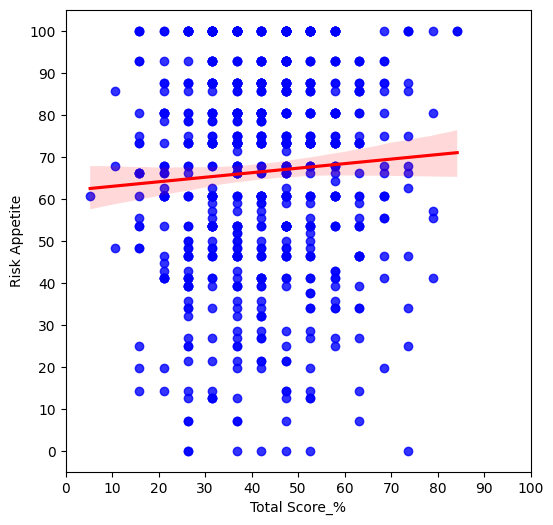

In [157]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = (main["RiskAppetite1_%"] + main["RiskAppetite2_%"])/2, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Risk Appetite', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## Financial Planning 1 vs risk literacy

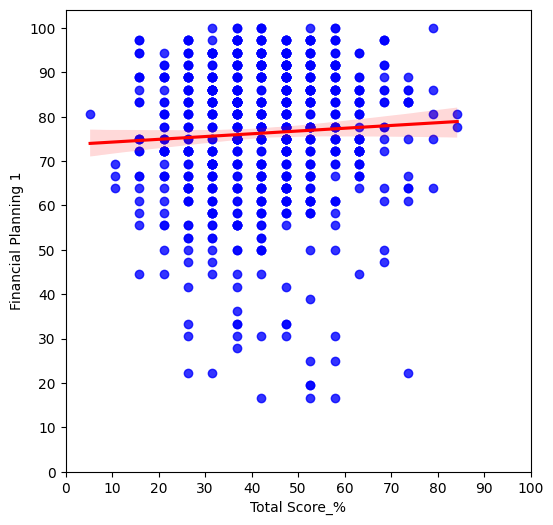

In [158]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["FinancialPlanning1_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Financial Planning 1', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## Financial Planning 2 vs risk literacy

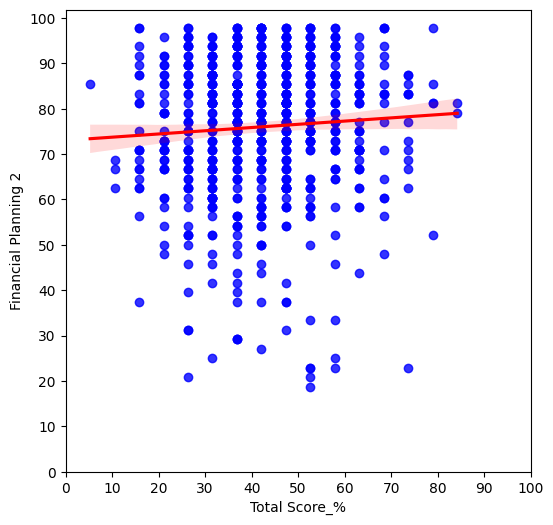

In [159]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["FinancialPlanning2_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Financial Planning 2', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## Risky Assets ownership vs risk literacy

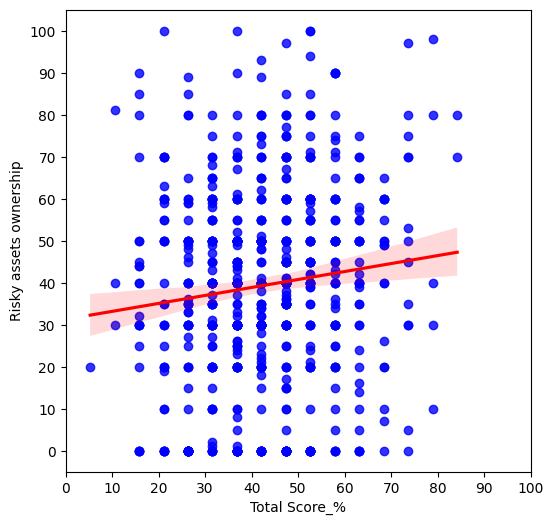

In [160]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["RiskAssets_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Risky assets ownership', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## Safe Assets ownership vs risk literacy

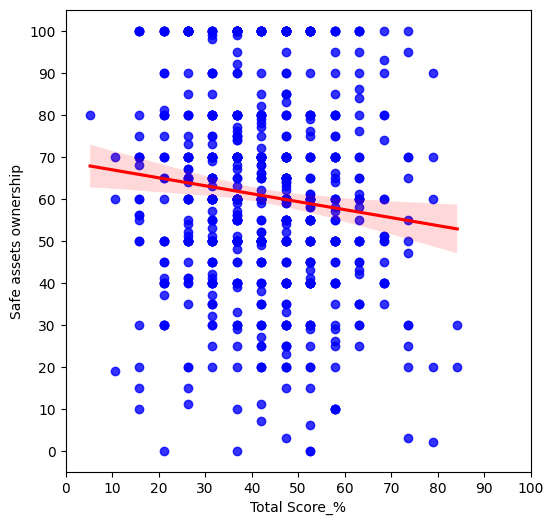

In [161]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["SafeAssets_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Safe assets ownership', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## Financial Literacy vs risk literacy

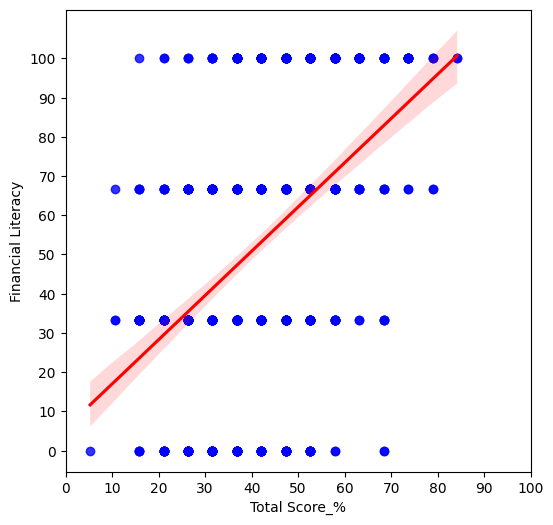

In [162]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["FinancialLiteracy_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Financial Literacy', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## CRT vs risk literacy

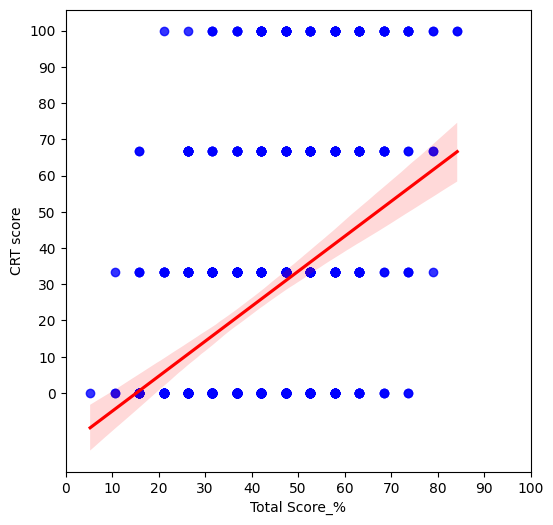

In [163]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["CRTScore_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='CRT score', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## Risk Alignment residuals vs Risk Literacy

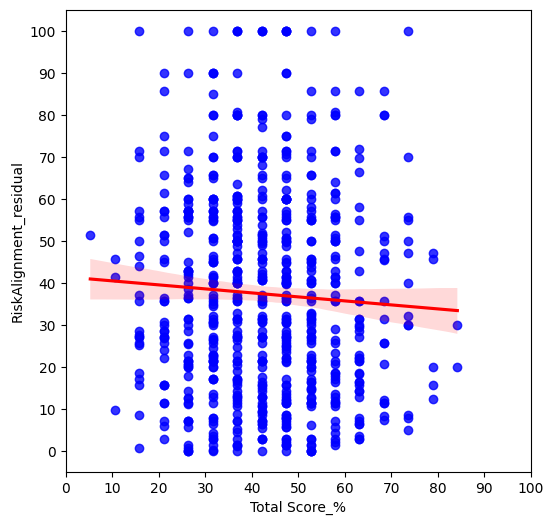

In [164]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["RiskAlignment_residual"].abs(), scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='RiskAlignment_residual', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

In [165]:
print("Correlation coefficient between Risk Lit and", 
      "absolute value of risk alignement residuals: \n", 
      main["TotalScore_%"].corr(main["RiskAlignment_residual"].abs(), method = "pearson"))

Correlation coefficient between Risk Lit and absolute value of risk alignement residuals: 
 -0.05578777989230579


## Risk Alignment (Felix) vs Risk Literacy

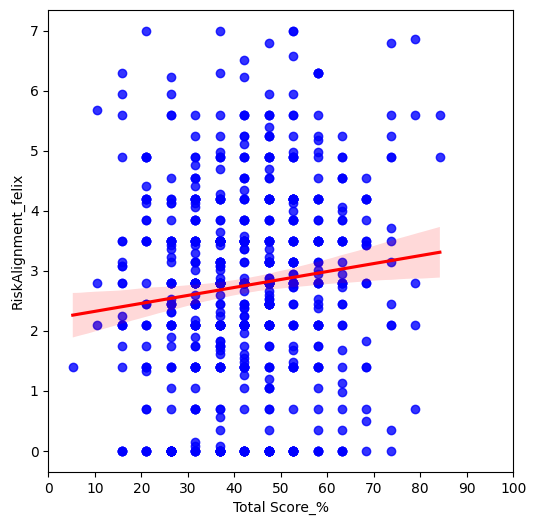

In [166]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["RiskAlignment_felix"].abs(), scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='RiskAlignment_felix', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 8, step = 1))
plt.show()

In [167]:
print("Correlation coefficient between Risk Lit and", 
      "absolute value of risk alignement residuals: \n", 
      main["TotalScore_%"].corr(main["RiskAlignment_felix"].abs(), method = "pearson"))

Correlation coefficient between Risk Lit and absolute value of risk alignement residuals: 
 0.11461750967071624


## Table Output

In [168]:

def regression_output(data: pd.DataFrame, regression_type: str, dependent_variable: str, independent_variable: str,
                      control_variables: list, depvar_absval: bool = False) -> pd.DataFrame :
    
    if depvar_absval == True:
        data[dependent_variable] = data[dependent_variable].abs().copy()

    if regression_type == "OLS":

        model = sm.OLS(data[dependent_variable],
                       sm.add_constant(data[[independent_variable] + control_variables]))
        res = model.fit()
    
    elif regression_type == "OrderedModel":

        data[dependent_variable] = pd.Categorical(data[dependent_variable], ordered=True)

        model = OrderedModel(data[dependent_variable],
                             data[[independent_variable] + control_variables], distr='logit')
        res = model.fit(method='bfgs')

    else:
        raise ValueError("Unsupported regression_type. Use 'OLS' or 'OrderedModel'.")
    
    def format_coefficient(coef, pval):
        if pval < 0.01:
            stars = "***"
        elif pval < 0.05:
            stars = "**"
        elif pval < 0.10:
            stars = "*"
        else:
            stars = ""
        return f"{coef:.3f}{stars}"
    
    def format_p_value(pval):
        return f'="({pval:.3f})"'
    
    # output = pd.DatFrame(index = ["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"])

    rows = []
    for var, coeff, pval in zip(res.params.index, res.params, res.pvalues):
        rows.append([var, str(format_coefficient(coeff, pval))])
        rows.append(["", str(format_p_value(pval))])
    
    output = pd.DataFrame(data = rows, columns = [regression_type, dependent_variable])
    return output


In [ ]:
data = finplan2_data.copy()
import csv
pd.concat([ regression_output(data = data, regression_type = "OLS", dependent_variable = "risky_investments",
                              independent_variable = "risklit_quartile", control_variables = ["isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"],
                              depvar_absval = False),
            regression_output(data = data, regression_type = "OLS", dependent_variable = "risky_investments",
                              independent_variable = "risklit_quartile", control_variables = ["isced", "age_rec", "FinancialLiteracy_%"],
                              depvar_absval = False)],
                              axis = 1).replace({pd.NA:""})



,OLS,risky_investments,OLS,risky_investments
0,const,42.172***,const,42.160***
1,,"=""(0.000)""",,"=""(0.000)"""
2,risklit_quartile,0.487,risklit_quartile,0.359
3,,"=""(0.597)""",,"=""(0.688)"""
4,isced,-5.576***,isced,-5.561***
5,,"=""(0.000)""",,"=""(0.000)"""
6,age_rec,0.931,age_rec,0.958
7,,"=""(0.509)""",,"=""(0.496)"""
8,FinancialLiteracy_%,0.092***,FinancialLiteracy_%,0.088***
9,,"=""(0.002)""",,"=""(0.002)"""
